# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## (1) compute camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from scipy.stats import norm
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
%matplotlib inline

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
imgShapes = []

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    imgShapes.append(img.shape)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [3]:
# In this project, image shape at numpy is (720, 1280, 3)
# There are 720 rows, 1280 cols, and each pixel contains 3 color elements.
imgShape = np.mean(imgShapes, 0).astype(int)
# Image size for cv2 is (1280, 720)
img_size = (imgShape[1], imgShape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


## (2) undistort / fine lanes / switch perspective / fit 

In [4]:
def HLS_S_select(img, thresh=(0,255)):
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = HLS[:,:,2]
    binary_out = np.zeros_like(S)
    binary_out[(S>=thresh[0])&(S<thresh[1])]=1
    return binary_out

def RGB_R_select(img, thresh=(0,255)):
    R = img[:,:,0]
    binary_out = np.zeros_like(R)
    binary_out[(R>=thresh[0])&(R<thresh[1])]=1
    return binary_out

def window_mask(width, height, img, center,level):
    output = np.zeros_like(img)
    output[max(0,int(img.shape[0]-(level+1)*height)):max(0,int(img.shape[0]-level*height)),
           max(0,int(center-width/2)):min(int(center+width/2),img.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_w_sigma, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
#     window = np.ones(window_width) # Create our window template that we will use for convolutions
    # Plot between -10 and 10 with .001 steps.
    x_axis = np.arange(-window_width/2, window_width/2, 1)
    # Mean = 0, SD = 10.
    window = norm.pdf(x_axis,0,window_w_sigma)
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum half bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(warped.shape[0]/2):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum,'same')) #convolve with same padding
    r_sum = np.sum(warped[int(warped.shape[0]/2):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum,'same'))+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
#     window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range((int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[(warped.shape[0]-(level+1)*window_height):(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer, 'same')
        # Find the best left centroid by using past left center as a reference
        l_min_index = int(max(l_center-margin,0))
        l_max_index = int(min(l_center+margin,warped.shape[1]-1))
        l_density = np.sum(image_layer[l_min_index:l_max_index]) / (l_max_index-l_min_index)
        l_BG= (np.sum(image_layer[0:l_min_index])+np.sum(image_layer[l_max_index:(int)((l_center+r_center)/2)]))
        l_BG_density = l_BG /(l_min_index-0+(int)((l_center-0+r_center)/2)-l_max_index)
        if l_density>l_BG_density:
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center-margin,0))
        r_max_index = int(min(r_center+margin,warped.shape[1]-1))
        r_density = np.sum(image_layer[r_min_index:r_max_index]) / (r_max_index-r_min_index)
        r_BG = (np.sum(image_layer[(int)((l_center+r_center)/2):r_min_index])+np.sum(image_layer[l_max_index:warped.shape[1]-1]))
        r_BG_density = r_BG / (r_min_index-(int)((l_center+r_center)/2)+warped.shape[1]-1-l_max_index)
        if r_density>r_BG_density:
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def ImageOverlay(img1, img2):
    img2IsZero = (img2==0)
    return img1*img2IsZero + img2

In [5]:
all_good_l_lane_x = []
all_good_l_lane_y = []
all_good_r_lane_x = []
all_good_r_lane_y = []
def FindLaneAndDraw(img, mtx, dist, imgShape, aglx, agly, agrx, agry):
    img_undistort = cv2.undistort(img, mtx, dist, None, mtx)


    S_binary = HLS_S_select(img, thresh=(100,256))
    R_binary = RGB_R_select(img, thresh=(200,256))

    combine_binary = (S_binary & R_binary) 

    pIni = np.float32([[217,720], [566,470], [720,470], [1113,720]])
    pFin = np.float32([[1.0/4*imgShape[1],imgShape[0]],[1.0/4*imgShape[1],1.0/3*imgShape[0]],
                       [3.0/4*imgShape[1],1.0/3*imgShape[0]],[3.0/4*imgShape[1],imgShape[0]]])
    M = cv2.getPerspectiveTransform(pIni, pFin)
    Minv = cv2.getPerspectiveTransform(pFin, pIni)
    img_warped = cv2.warpPerspective(combine_binary, M, img_size, flags=cv2.INTER_LINEAR)

    if len(img_warped.shape)==3:
        warped = cv2.cvtColor(img_warped, cv2.COLOR_RGB2GRAY)
    else:
        warped = img_warped*255
    # window settings
    window_width = 300
    window_w_sigma = 50
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = window_width/2 # How much to slide left and right for searching

    window_centroids = find_window_centroids(warped, window_width, window_w_sigma, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_lane_mask = np.zeros_like(warped)
        r_lane_mask = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_lane_mask[l_mask == 1] = 255
            r_lane_mask[r_mask == 1] = 255

        l_lane = warped & l_lane_mask
        r_lane = warped & r_lane_mask
    # If no window centers found, just display orginal road image
    else:
        l_lane_mask = np.zeros_like(warped)
        r_lane_mask = np.zeros_like(warped)
        l_lane = warped & l_lane_mask
        r_lane = warped & r_lane_mask

    #left/right lanes pixels MvAvg #frames
    lane_pixels_MvSum_frames = 10
    l_lane_nonzero = l_lane.nonzero()
    if len(l_lane_nonzero[1])>0:
        aglx.append(l_lane_nonzero[1]) 
        agly.append(l_lane_nonzero[0])
    else: #this will cause duplicated data hence affecting MvAvg, but can prevent un-sync of left/right lane sampling times
        aglx.append(aglx[-1])
        agly.append(agly[-1])
    if len(aglx)>lane_pixels_MvSum_frames:
        l_lane_x = np.concatenate(aglx[len(aglx)-lane_pixels_MvSum_frames:-1])
        l_lane_y = np.concatenate(agly[len(agly)-lane_pixels_MvSum_frames:-1])
    else:
        l_lane_x = np.concatenate(aglx[:])
        l_lane_y = np.concatenate(agly[:])

    r_lane_nonzero = r_lane.nonzero()
    if len(r_lane_nonzero[1])>0:
        agrx.append(r_lane_nonzero[1]) 
        agry.append(r_lane_nonzero[0])  
    else:
        agrx.append(agrx[-1])
        agry.append(agry[-1])
    if len(agrx)>lane_pixels_MvSum_frames:
        r_lane_x = np.concatenate(agrx[len(agrx)-lane_pixels_MvSum_frames:-1])
        r_lane_y = np.concatenate(agry[len(agry)-lane_pixels_MvSum_frames:-1])
    else:
        r_lane_x = np.concatenate(agrx[:])
        r_lane_y = np.concatenate(agry[:])


    l_fit = np.polyfit(l_lane_y, l_lane_x, 2)
    r_fit = np.polyfit(r_lane_y, r_lane_x, 2)
    l_fit_weight = len(l_lane_y)
    r_fit_weight = len(r_lane_y)
    l_interp = np.poly1d(l_fit)
    r_interp = np.poly1d(r_fit)

    ys = np.linspace(0, imgShape[0]-1, imgShape[0])

    lane_width_pixels = imgShape[1]/2
    dash_length_pixels = 90
    lane_width_meters = 3.7
    dash_length_meters = 3
    x_pixel2meter = lane_width_meters/lane_width_pixels
    y_pixel2meter = dash_length_meters/dash_length_pixels

    ys_meter = ys*y_pixel2meter

    l_lane_x_meter = l_lane_x * x_pixel2meter
    l_lane_y_meter = l_lane_y * y_pixel2meter

    r_lane_x_meter = r_lane_x * x_pixel2meter
    r_lane_y_meter = r_lane_y * y_pixel2meter

    l_fit_meter = np.polyfit(l_lane_y_meter, l_lane_x_meter, 2)
    r_fit_meter = np.polyfit(r_lane_y_meter, r_lane_x_meter, 2)
    l_interp_meter = np.poly1d(l_fit_meter)
    r_interp_meter = np.poly1d(r_fit_meter)

    # Curvature radius
    y_max_meter = np.max(ys_meter)
    l_curvR_meter = ((1 + (2*l_fit_meter[0]*y_max_meter + l_fit_meter[1])**2)**1.5) / np.absolute(2*l_fit_meter[0])
    r_curvR_meter = ((1 + (2*r_fit_meter[0]*y_max_meter + r_fit_meter[1])**2)**1.5) / np.absolute(2*r_fit_meter[0])
    print(l_curvR_meter, r_curvR_meter)

    # offset position to lane center
    vehicle_offset_meter = imgShape[1]/2*x_pixel2meter - (l_interp_meter(y_max_meter)+r_interp_meter(y_max_meter))/2 


    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_l_lane = np.array(np.transpose(np.stack((l_interp(ys), ys),0)))
    pts_r_lane = np.array(np.flipud(np.transpose(np.stack((r_interp(ys), ys),0))))
    pts = np.concatenate((pts_l_lane, pts_r_lane),0)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size, flags=cv2.INTER_LINEAR) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undistort, 1, newwarp, 0.3, 0)

    #add on screen texts describing current driving condition calculations
    onScreenTextImage = Image.new("RGB", (1280,720), (0,0,0))
    draw = ImageDraw.Draw(onScreenTextImage)
    colorText = (255,0,0)
    fontLarge = ImageFont.truetype("arial.ttf", 50)
    fontSmall = ImageFont.truetype("arial.ttf", 30)
    avg_curvR_meter = (l_curvR_meter*l_fit_weight+r_curvR_meter*r_fit_weight) / (l_fit_weight+r_fit_weight)
    draw.text((50,50), 'Lane Curvature Radius = {:.1f} km'.format(avg_curvR_meter/1000),  colorText, font=fontLarge) 
    draw.text((50,100), 'Vehicle Offset from Lane Center = {:.1f} m'.format(vehicle_offset_meter), colorText, font=fontLarge) 
    draw.text((50,150),'left_fit = '+str(l_fit),  colorText, font=fontSmall) 
    draw.text((50,180),'right_fit = '+str(r_fit),  colorText, font=fontSmall)  
    onScreenText = np.array(onScreenTextImage.getdata()).reshape(onScreenTextImage.size[1], onScreenTextImage.size[0], 3).astype('uint8')

    return ImageOverlay(result, onScreenText)


1443.25567012 4969.57408737


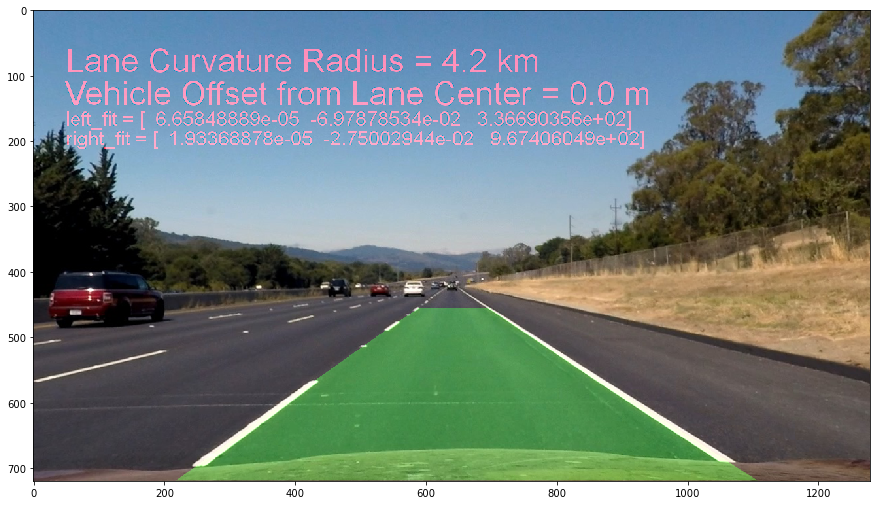

In [6]:
# Read raw image to be undistorted
imgFile = r'..\test_images\straight_lines2.jpg'
# imgFile = r'..\test_images\test6.jpg'
img = mpimg.imread(imgFile)

plt.figure(figsize=(15,15))
rst = FindLaneAndDraw(img, mtx, dist, imgShape, 
                    all_good_l_lane_x, all_good_l_lane_y, all_good_r_lane_x, all_good_r_lane_y)
plt.imshow(rst)

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def FindLane(image):
    return FindLaneAndDraw(image, mtx, dist, imgShape, 
                        all_good_l_lane_x, all_good_l_lane_y, all_good_r_lane_x, all_good_r_lane_y);

In [9]:
white_output = '../ProjectVideoOut.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4")#.subclip(0,2)
white_clip = clip1.fl_image(FindLane) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

254.307957235 41448.6559258
[MoviePy] >>>> Building video ../ProjectVideoOut.mp4
[MoviePy] Writing video ../ProjectVideoOut.mp4


  0%|                                                      | 0/1261 [00:00<?, ?it/s]

273.302845273 7602.59204099


  0%|                                              | 1/1261 [00:01<22:28,  1.07s/it]

280.121851255 2366.31272009


  0%|                                              | 2/1261 [00:02<22:57,  1.09s/it]

283.347293918 832.818635611


  0%|                                              | 3/1261 [00:03<22:52,  1.09s/it]

285.381001756 526.990906143


  0%|▏                                             | 4/1261 [00:04<22:00,  1.05s/it]

286.722844225 460.94575946


  0%|▏                                             | 5/1261 [00:05<21:54,  1.05s/it]

288.619254612 467.825495943


  0%|▏                                             | 6/1261 [00:06<21:28,  1.03s/it]

291.670170817 488.910491538


  1%|▎                                             | 7/1261 [00:07<21:17,  1.02s/it]

294.753116948 516.031449365


  1%|▎                                             | 8/1261 [00:08<20:58,  1.00s/it]

308.573227482 1147.41399164


  1%|▎                                             | 9/1261 [00:09<20:56,  1.00s/it]

311.122062917 1281.01566337


  1%|▎                                            | 10/1261 [00:10<21:13,  1.02s/it]

315.168024136 610.859877016


  1%|▍                                            | 11/1261 [00:11<22:20,  1.07s/it]

322.354405771 447.988815224


  1%|▍                                            | 12/1261 [00:12<22:16,  1.07s/it]

333.511071673 420.915352124


  1%|▍                                            | 13/1261 [00:13<21:32,  1.04s/it]

347.035671778 416.882487291


  1%|▍                                            | 14/1261 [00:14<22:43,  1.09s/it]

362.675354011 414.37989785


  1%|▌                                            | 15/1261 [00:15<22:40,  1.09s/it]

377.423416852 388.431542589


  1%|▌                                            | 16/1261 [00:16<21:39,  1.04s/it]

389.989418409 375.204448084


  1%|▌                                            | 17/1261 [00:17<20:59,  1.01s/it]

400.188091517 386.37344899


  1%|▋                                            | 18/1261 [00:18<20:28,  1.01it/s]

408.705245271 517.379299406


  2%|▋                                            | 19/1261 [00:19<20:06,  1.03it/s]

417.863194304 744.550327833


  2%|▋                                            | 20/1261 [00:20<19:53,  1.04it/s]

427.065922219 1389.87932094


  2%|▋                                            | 21/1261 [00:21<19:35,  1.05it/s]

434.00217084 1788.50007019


  2%|▊                                            | 22/1261 [00:22<19:34,  1.05it/s]

443.696517766 822.186283465


  2%|▊                                            | 23/1261 [00:23<19:30,  1.06it/s]

451.623295905 335.747697722


  2%|▊                                            | 24/1261 [00:24<19:24,  1.06it/s]

455.491439603 212.748830927


  2%|▉                                            | 25/1261 [00:25<19:14,  1.07it/s]

454.683045634 243.862851549


  2%|▉                                            | 26/1261 [00:26<19:12,  1.07it/s]

457.10497999 592.635171754


  2%|▉                                            | 27/1261 [00:27<19:07,  1.07it/s]

456.49532202 4336.86503493


  2%|▉                                            | 28/1261 [00:27<19:07,  1.07it/s]

454.041168174 2106.65470662


  2%|█                                            | 29/1261 [00:28<19:06,  1.07it/s]

444.689473263 5634.73387064


  2%|█                                            | 30/1261 [00:29<19:00,  1.08it/s]

427.117653313 1905.734193


  2%|█                                            | 31/1261 [00:30<19:03,  1.08it/s]

403.461258017 1202.56671663


  3%|█▏                                           | 32/1261 [00:31<19:08,  1.07it/s]

377.503047476 1478.5289636


  3%|█▏                                           | 33/1261 [00:32<19:08,  1.07it/s]

356.868829426 1409.48226188


  3%|█▏                                           | 34/1261 [00:33<19:17,  1.06it/s]

339.61846893 1664.15906647


  3%|█▏                                           | 35/1261 [00:34<19:10,  1.07it/s]

321.535563719 6602.65205959


  3%|█▎                                           | 36/1261 [00:35<19:07,  1.07it/s]

305.34072378 11995.2363721


  3%|█▎                                           | 37/1261 [00:36<18:58,  1.07it/s]

289.137694875 1175.01869386


  3%|█▎                                           | 38/1261 [00:37<19:10,  1.06it/s]

275.135299072 404.077242899


  3%|█▍                                           | 39/1261 [00:38<19:08,  1.06it/s]

263.963155922 300.296538812


  3%|█▍                                           | 40/1261 [00:39<19:09,  1.06it/s]

256.321670379 231.380755231


  3%|█▍                                           | 41/1261 [00:40<18:59,  1.07it/s]

250.981298597 199.767039722


  3%|█▍                                           | 42/1261 [00:41<19:00,  1.07it/s]

245.938401919 235.67358175


  3%|█▌                                           | 43/1261 [00:42<19:23,  1.05it/s]

243.026177494 283.985064901


  3%|█▌                                           | 44/1261 [00:42<19:10,  1.06it/s]

242.489180259 323.426838963


  4%|█▌                                           | 45/1261 [00:43<19:07,  1.06it/s]

243.489599897 317.374240007


  4%|█▋                                           | 46/1261 [00:44<19:01,  1.06it/s]

245.558478024 277.158355484


  4%|█▋                                           | 47/1261 [00:45<19:03,  1.06it/s]

250.072132298 233.937882705


  4%|█▋                                           | 48/1261 [00:46<19:01,  1.06it/s]

257.267495098 213.339453488


  4%|█▋                                           | 49/1261 [00:47<19:08,  1.06it/s]

266.430160355 192.997321922


  4%|█▊                                           | 50/1261 [00:48<19:09,  1.05it/s]

277.805789881 198.638754093


  4%|█▊                                           | 51/1261 [00:49<19:14,  1.05it/s]

290.806245127 263.316701402


  4%|█▊                                           | 52/1261 [00:50<19:06,  1.05it/s]

305.225262206 283.885064782


  4%|█▉                                           | 53/1261 [00:51<18:59,  1.06it/s]

319.848279044 238.935213579


  4%|█▉                                           | 54/1261 [00:52<18:56,  1.06it/s]

335.615160795 197.749191401


  4%|█▉                                           | 55/1261 [00:53<19:03,  1.05it/s]

352.999612945 202.749234456


  4%|█▉                                           | 56/1261 [00:54<19:04,  1.05it/s]

370.717744942 218.7974844


  5%|██                                           | 57/1261 [00:55<19:02,  1.05it/s]

388.548060097 234.37226612


  5%|██                                           | 58/1261 [00:56<19:09,  1.05it/s]

402.811032035 279.921407032


  5%|██                                           | 59/1261 [00:57<18:59,  1.05it/s]

411.064699481 424.365606577


  5%|██▏                                          | 60/1261 [00:58<18:59,  1.05it/s]

414.642479197 1074.10669782


  5%|██▏                                          | 61/1261 [00:59<18:54,  1.06it/s]

414.233502762 428.552815485


  5%|██▏                                          | 62/1261 [01:00<19:00,  1.05it/s]

412.45668597 326.107358271


  5%|██▏                                          | 63/1261 [01:00<18:56,  1.05it/s]

408.753885282 299.907238955


  5%|██▎                                          | 64/1261 [01:01<18:57,  1.05it/s]

401.273101215 253.180127146


  5%|██▎                                          | 65/1261 [01:02<19:04,  1.05it/s]

392.546273342 210.365969616


  5%|██▎                                          | 66/1261 [01:03<19:05,  1.04it/s]

383.844646812 189.914845574


  5%|██▍                                          | 67/1261 [01:04<19:11,  1.04it/s]

376.247424074 233.356637722


  5%|██▍                                          | 68/1261 [01:05<19:06,  1.04it/s]

374.506657798 270.78703725


  5%|██▍                                          | 69/1261 [01:06<19:00,  1.05it/s]

373.393860666 299.576138479


  6%|██▍                                          | 70/1261 [01:07<18:57,  1.05it/s]

375.29509163 306.056123717


  6%|██▌                                          | 71/1261 [01:08<18:54,  1.05it/s]

378.146498941 349.556172328


  6%|██▌                                          | 72/1261 [01:09<18:53,  1.05it/s]

384.346919615 412.935920752


  6%|██▌                                          | 73/1261 [01:10<18:50,  1.05it/s]

394.001638608 542.183671126


  6%|██▋                                          | 74/1261 [01:11<18:48,  1.05it/s]

407.178264362 855.55154003


  6%|██▋                                          | 75/1261 [01:12<18:41,  1.06it/s]

424.465803518 1297.47993676


  6%|██▋                                          | 76/1261 [01:13<19:02,  1.04it/s]

443.250214067 1640.96709244


  6%|██▋                                          | 77/1261 [01:14<20:30,  1.04s/it]

469.457723434 2773.67313829


  6%|██▊                                          | 78/1261 [01:15<21:17,  1.08s/it]

505.051533841 8063.55100244


  6%|██▊                                          | 79/1261 [01:16<21:03,  1.07s/it]

543.876926576 3716.05247425


  6%|██▊                                          | 80/1261 [01:17<20:13,  1.03s/it]

580.52111008 1141.40138076


  6%|██▉                                          | 81/1261 [01:18<19:44,  1.00s/it]

610.861332763 738.410476261


  7%|██▉                                          | 82/1261 [01:19<19:20,  1.02it/s]

637.052264421 537.312415813


  7%|██▉                                          | 83/1261 [01:20<19:06,  1.03it/s]

650.405323498 518.061670166


  7%|██▉                                          | 84/1261 [01:21<18:59,  1.03it/s]

656.133999022 385.906521916


  7%|███                                          | 85/1261 [01:22<18:47,  1.04it/s]

652.71216318 341.39714496


  7%|███                                          | 86/1261 [01:23<18:45,  1.04it/s]

626.502090384 320.801768801


  7%|███                                          | 87/1261 [01:24<18:34,  1.05it/s]

584.081585672 331.623057143


  7%|███▏                                         | 88/1261 [01:25<18:34,  1.05it/s]

537.095663164 274.253351818


  7%|███▏                                         | 89/1261 [01:26<18:22,  1.06it/s]

495.339455938 246.911404614


  7%|███▏                                         | 90/1261 [01:27<18:29,  1.06it/s]

454.983862124 208.968213791


  7%|███▏                                         | 91/1261 [01:28<18:30,  1.05it/s]

424.496847382 183.563182287


  7%|███▎                                         | 92/1261 [01:29<18:23,  1.06it/s]

400.70470232 198.284604388


  7%|███▎                                         | 93/1261 [01:30<18:26,  1.06it/s]

376.526401863 239.746794251


  7%|███▎                                         | 94/1261 [01:31<18:31,  1.05it/s]

354.982406762 302.801497114


  8%|███▍                                         | 95/1261 [01:32<18:36,  1.04it/s]

339.084060907 389.081956962


  8%|███▍                                         | 96/1261 [01:32<18:30,  1.05it/s]

329.781115348 477.279377639


  8%|███▍                                         | 97/1261 [01:33<18:27,  1.05it/s]

324.024848838 542.795626154


  8%|███▍                                         | 98/1261 [01:34<18:14,  1.06it/s]

321.585349298 597.100093951


  8%|███▌                                         | 99/1261 [01:35<18:17,  1.06it/s]

322.778902279 613.998703939


  8%|███▍                                        | 100/1261 [01:36<18:12,  1.06it/s]

324.546841805 643.150505165


  8%|███▌                                        | 101/1261 [01:37<18:14,  1.06it/s]

325.618453253 651.315476576


  8%|███▌                                        | 102/1261 [01:38<18:10,  1.06it/s]

327.078440229 601.509866796


  8%|███▌                                        | 103/1261 [01:39<18:12,  1.06it/s]

329.976757101 505.804957865


  8%|███▋                                        | 104/1261 [01:40<18:20,  1.05it/s]

331.725313092 446.723266473


  8%|███▋                                        | 105/1261 [01:41<18:55,  1.02it/s]

334.90192759 430.209384104


  8%|███▋                                        | 106/1261 [01:42<18:57,  1.02it/s]

337.987677848 423.082330786


  8%|███▋                                        | 107/1261 [01:43<18:37,  1.03it/s]

341.545305025 353.957643513


  9%|███▊                                        | 108/1261 [01:44<18:29,  1.04it/s]

342.045391921 279.878300459


  9%|███▊                                        | 109/1261 [01:45<18:25,  1.04it/s]

339.69683528 223.728397982


  9%|███▊                                        | 110/1261 [01:46<18:25,  1.04it/s]

337.113758131 186.722902056


  9%|███▊                                        | 111/1261 [01:47<18:29,  1.04it/s]

334.848208329 176.923178483


  9%|███▉                                        | 112/1261 [01:48<18:17,  1.05it/s]

334.738977367 215.327802202


  9%|███▉                                        | 113/1261 [01:49<18:16,  1.05it/s]

332.128666465 265.65423188


  9%|███▉                                        | 114/1261 [01:50<18:20,  1.04it/s]

327.161172105 349.49630764


  9%|████                                        | 115/1261 [01:51<18:39,  1.02it/s]

319.892897456 445.993661095


  9%|████                                        | 116/1261 [01:52<18:22,  1.04it/s]

311.204925288 500.028570591


  9%|████                                        | 117/1261 [01:53<18:17,  1.04it/s]

305.509181829 483.873603736


  9%|████                                        | 118/1261 [01:54<18:21,  1.04it/s]

299.711459974 455.99380761


  9%|████▏                                       | 119/1261 [01:55<18:13,  1.04it/s]

294.902596288 453.720701604


 10%|████▏                                       | 120/1261 [01:55<18:14,  1.04it/s]

289.120386452 471.92872762


 10%|████▏                                       | 121/1261 [01:56<18:12,  1.04it/s]

282.292843176 481.727332175


 10%|████▎                                       | 122/1261 [01:57<17:56,  1.06it/s]

278.436670375 480.997423124


 10%|████▎                                       | 123/1261 [01:58<17:51,  1.06it/s]

274.316540996 452.682286027


 10%|████▎                                       | 124/1261 [01:59<17:49,  1.06it/s]

273.020508849 412.20963941


 10%|████▎                                       | 125/1261 [02:00<17:50,  1.06it/s]

272.334101122 368.753111105


 10%|████▍                                       | 126/1261 [02:01<17:52,  1.06it/s]

273.127081196 296.283528818


 10%|████▍                                       | 127/1261 [02:02<18:04,  1.05it/s]

274.454256517 263.830507208


 10%|████▍                                       | 128/1261 [02:03<17:57,  1.05it/s]

276.754769011 295.440182114


 10%|████▌                                       | 129/1261 [02:04<17:49,  1.06it/s]

280.490528098 323.272266517


 10%|████▌                                       | 130/1261 [02:05<17:49,  1.06it/s]

283.551069798 339.743995159


 10%|████▌                                       | 131/1261 [02:06<17:51,  1.05it/s]

286.650751341 363.81503662


 10%|████▌                                       | 132/1261 [02:07<17:49,  1.06it/s]

290.866871106 377.027270046


 11%|████▋                                       | 133/1261 [02:08<17:46,  1.06it/s]

295.549717257 378.515172563


 11%|████▋                                       | 134/1261 [02:09<17:50,  1.05it/s]

300.875983257 368.19775085


 11%|████▋                                       | 135/1261 [02:10<17:51,  1.05it/s]

305.635503614 366.34124085


 11%|████▋                                       | 136/1261 [02:11<17:53,  1.05it/s]

312.678643102 318.254734822


 11%|████▊                                       | 137/1261 [02:12<17:45,  1.05it/s]

319.162359999 227.523481088


 11%|████▊                                       | 138/1261 [02:13<18:30,  1.01it/s]

328.172799369 192.214668085


 11%|████▊                                       | 139/1261 [02:14<18:17,  1.02it/s]

337.943829775 212.808486329


 11%|████▉                                       | 140/1261 [02:15<18:06,  1.03it/s]

351.597391947 315.556369848


 11%|████▉                                       | 141/1261 [02:16<18:16,  1.02it/s]

364.928559455 2945.39629458


 11%|████▉                                       | 142/1261 [02:17<18:27,  1.01it/s]

379.058318758 1137.89089953


 11%|████▉                                       | 143/1261 [02:18<18:35,  1.00it/s]

390.451937967 2486.3049245


 11%|█████                                       | 144/1261 [02:19<18:47,  1.01s/it]

399.268100511 840.840966465


 11%|█████                                       | 145/1261 [02:20<19:33,  1.05s/it]

407.408209323 623.776015349


 12%|█████                                       | 146/1261 [02:21<19:29,  1.05s/it]

412.937244024 644.077238126


 12%|█████▏                                      | 147/1261 [02:22<19:07,  1.03s/it]

417.245371418 777.151268243


 12%|█████▏                                      | 148/1261 [02:23<18:35,  1.00s/it]

414.854927385 2085.87522277


 12%|█████▏                                      | 149/1261 [02:24<18:10,  1.02it/s]

409.131470739 4560.71390616


 12%|█████▏                                      | 150/1261 [02:25<17:53,  1.03it/s]

406.611941786 16194.2439093


 12%|█████▎                                      | 151/1261 [02:26<17:48,  1.04it/s]

405.007255882 1210.66949136


 12%|█████▎                                      | 152/1261 [02:26<17:42,  1.04it/s]

406.159526759 1124.03589424


 12%|█████▎                                      | 153/1261 [02:27<17:45,  1.04it/s]

405.053348218 866.893178969


 12%|█████▎                                      | 154/1261 [02:28<17:57,  1.03it/s]

403.946740218 871.14631233


 12%|█████▍                                      | 155/1261 [02:29<17:42,  1.04it/s]

404.700453938 1121.9544267


 12%|█████▍                                      | 156/1261 [02:30<17:43,  1.04it/s]

402.608807679 1268.20967286


 12%|█████▍                                      | 157/1261 [02:31<17:39,  1.04it/s]

405.107228486 794.070315897


 13%|█████▌                                      | 158/1261 [02:32<17:58,  1.02it/s]

402.449280825 636.925998198


 13%|█████▌                                      | 159/1261 [02:33<17:41,  1.04it/s]

396.823272543 717.671761389


 13%|█████▌                                      | 160/1261 [02:34<17:36,  1.04it/s]

388.258602189 1315.5447042


 13%|█████▌                                      | 161/1261 [02:35<17:39,  1.04it/s]

379.083093354 2305.75487784


 13%|█████▋                                      | 162/1261 [02:36<17:32,  1.04it/s]

374.37667533 8149.39355847


 13%|█████▋                                      | 163/1261 [02:37<17:22,  1.05it/s]

367.988876286 1949.96409062


 13%|█████▋                                      | 164/1261 [02:38<17:21,  1.05it/s]

361.881480633 818.531218535


 13%|█████▊                                      | 165/1261 [02:39<17:16,  1.06it/s]

356.498353849 503.435232042


 13%|█████▊                                      | 166/1261 [02:40<17:16,  1.06it/s]

353.351329492 254.489517343


 13%|█████▊                                      | 167/1261 [02:41<17:11,  1.06it/s]

349.674088436 196.179617433


 13%|█████▊                                      | 168/1261 [02:42<17:12,  1.06it/s]

350.354137055 216.825900581


 13%|█████▉                                      | 169/1261 [02:43<17:19,  1.05it/s]

354.380886971 228.094134385


 13%|█████▉                                      | 170/1261 [02:44<17:12,  1.06it/s]

360.329838468 248.315420976


 14%|█████▉                                      | 171/1261 [02:45<17:13,  1.05it/s]

365.552037462 266.472799083


 14%|██████                                      | 172/1261 [02:46<17:12,  1.05it/s]

369.763017991 302.178670938


 14%|██████                                      | 173/1261 [02:47<17:11,  1.05it/s]

372.414344493 389.961085528


 14%|██████                                      | 174/1261 [02:47<17:12,  1.05it/s]

372.928643384 671.393464805


 14%|██████                                      | 175/1261 [02:48<17:05,  1.06it/s]

371.748593294 9720.15205433


 14%|██████▏                                     | 176/1261 [02:49<17:00,  1.06it/s]

371.925985537 978.079611441


 14%|██████▏                                     | 177/1261 [02:50<17:14,  1.05it/s]

370.329103324 16215.4680183


 14%|██████▏                                     | 178/1261 [02:51<17:08,  1.05it/s]

368.531394156 741.40426949


 14%|██████▏                                     | 179/1261 [02:52<17:13,  1.05it/s]

362.928520664 512.73009083


 14%|██████▎                                     | 180/1261 [02:53<17:07,  1.05it/s]

356.48206465 1180.101288


 14%|██████▎                                     | 181/1261 [02:54<17:10,  1.05it/s]

345.023889736 3464.47026831


 14%|██████▎                                     | 182/1261 [02:55<16:59,  1.06it/s]

335.737020086 4430.45317813


 15%|██████▍                                     | 183/1261 [02:56<16:59,  1.06it/s]

326.511602037 974.085994739


 15%|██████▍                                     | 184/1261 [02:57<17:00,  1.05it/s]

316.041017552 488.700118109


 15%|██████▍                                     | 185/1261 [02:58<17:07,  1.05it/s]

305.265934824 393.116717854


 15%|██████▍                                     | 186/1261 [02:59<16:56,  1.06it/s]

288.538714877 531.032150594


 15%|██████▌                                     | 187/1261 [03:00<16:58,  1.05it/s]

273.225102005 1129.79466816


 15%|██████▌                                     | 188/1261 [03:01<16:47,  1.07it/s]

259.255637058 4280.41849298


 15%|██████▌                                     | 189/1261 [03:02<16:56,  1.05it/s]

247.838517808 3337.45718813


 15%|██████▋                                     | 190/1261 [03:03<16:49,  1.06it/s]

239.85754389 1466.23413027


 15%|██████▋                                     | 191/1261 [03:04<16:50,  1.06it/s]

231.781199326 171.890588363


 15%|██████▋                                     | 192/1261 [03:05<16:42,  1.07it/s]

226.834520507 143.8791531


 15%|██████▋                                     | 193/1261 [03:05<16:49,  1.06it/s]

223.902075233 151.90478729


 15%|██████▊                                     | 194/1261 [03:06<16:46,  1.06it/s]

223.633208584 180.603483313


 15%|██████▊                                     | 195/1261 [03:07<16:46,  1.06it/s]

226.666040371 200.129301023


 16%|██████▊                                     | 196/1261 [03:08<16:40,  1.06it/s]

234.254664834 195.458527391


 16%|██████▊                                     | 197/1261 [03:09<16:45,  1.06it/s]

245.79870229 145.055197491


 16%|██████▉                                     | 198/1261 [03:10<16:40,  1.06it/s]

259.556277397 99.8528693191


 16%|██████▉                                     | 199/1261 [03:11<16:37,  1.07it/s]

276.628137666 73.3390429927


 16%|██████▉                                     | 200/1261 [03:12<16:35,  1.07it/s]

295.522378399 93.6184192894


 16%|███████                                     | 201/1261 [03:13<16:32,  1.07it/s]

316.960223211 381.070983615


 16%|███████                                     | 202/1261 [03:14<16:32,  1.07it/s]

335.137942393 1152.65456364


 16%|███████                                     | 203/1261 [03:15<16:35,  1.06it/s]

351.582645406 3194.72517653


 16%|███████                                     | 204/1261 [03:16<16:37,  1.06it/s]

367.407284333 591.083457465


 16%|███████▏                                    | 205/1261 [03:17<16:38,  1.06it/s]

373.839172267 325.404696774


 16%|███████▏                                    | 206/1261 [03:18<16:43,  1.05it/s]

373.728335724 282.290993825


 16%|███████▏                                    | 207/1261 [03:19<16:42,  1.05it/s]

362.985233453 341.116325511


 16%|███████▎                                    | 208/1261 [03:20<16:40,  1.05it/s]

347.679858089 841.512778317


 17%|███████▎                                    | 209/1261 [03:21<16:45,  1.05it/s]

335.323141243 5113.94290827


 17%|███████▎                                    | 210/1261 [03:22<16:43,  1.05it/s]

322.899873183 1992.16694572


 17%|███████▎                                    | 211/1261 [03:23<16:45,  1.04it/s]

316.544637733 208253.365873


 17%|███████▍                                    | 212/1261 [03:23<16:43,  1.05it/s]

309.902251358 941.357538405


 17%|███████▍                                    | 213/1261 [03:24<16:45,  1.04it/s]

304.636580369 522.427581774


 17%|███████▍                                    | 214/1261 [03:25<16:33,  1.05it/s]

300.077884404 430.293851272


 17%|███████▌                                    | 215/1261 [03:26<16:32,  1.05it/s]

296.337145095 379.040561114


 17%|███████▌                                    | 216/1261 [03:27<16:25,  1.06it/s]

296.003598542 298.234224445


 17%|███████▌                                    | 217/1261 [03:28<16:30,  1.05it/s]

297.248117696 232.642717301


 17%|███████▌                                    | 218/1261 [03:29<16:35,  1.05it/s]

298.725948082 215.654103019


 17%|███████▋                                    | 219/1261 [03:30<16:28,  1.05it/s]

298.388308563 225.678778014


 17%|███████▋                                    | 220/1261 [03:31<16:29,  1.05it/s]

299.002584072 287.658105233


 18%|███████▋                                    | 221/1261 [03:32<16:27,  1.05it/s]

301.803830421 388.538758776


 18%|███████▋                                    | 222/1261 [03:33<16:29,  1.05it/s]

305.111241954 528.257519824


 18%|███████▊                                    | 223/1261 [03:34<16:26,  1.05it/s]

311.91788994 622.052477493


 18%|███████▊                                    | 224/1261 [03:35<16:25,  1.05it/s]

318.737316799 635.010665117


 18%|███████▊                                    | 225/1261 [03:36<16:25,  1.05it/s]

327.298642877 561.626132295


 18%|███████▉                                    | 226/1261 [03:37<16:18,  1.06it/s]

337.748105318 442.428226459


 18%|███████▉                                    | 227/1261 [03:38<16:25,  1.05it/s]

347.585191349 335.699321424


 18%|███████▉                                    | 228/1261 [03:39<16:22,  1.05it/s]

360.508772378 265.81057516


 18%|███████▉                                    | 229/1261 [03:40<16:22,  1.05it/s]

369.659158409 267.027571873


 18%|████████                                    | 230/1261 [03:41<16:26,  1.05it/s]

380.342175515 285.946844254


 18%|████████                                    | 231/1261 [03:42<16:22,  1.05it/s]

388.580392652 315.403425515


 18%|████████                                    | 232/1261 [03:42<16:21,  1.05it/s]

397.123870647 338.24638503


 18%|████████▏                                   | 233/1261 [03:43<16:18,  1.05it/s]

408.393701696 371.111647094


 19%|████████▏                                   | 234/1261 [03:44<16:18,  1.05it/s]

418.621631176 441.482438965


 19%|████████▏                                   | 235/1261 [03:45<16:23,  1.04it/s]

426.492937568 647.897735422


 19%|████████▏                                   | 236/1261 [03:46<16:20,  1.05it/s]

426.465939053 1080.79949024


 19%|████████▎                                   | 237/1261 [03:47<16:23,  1.04it/s]

424.902403741 1708.88793617


 19%|████████▎                                   | 238/1261 [03:48<16:13,  1.05it/s]

422.186886831 880.066786975


 19%|████████▎                                   | 239/1261 [03:49<16:18,  1.04it/s]

413.525961964 332.033837048


 19%|████████▎                                   | 240/1261 [03:50<16:09,  1.05it/s]

406.173471505 219.368115864


 19%|████████▍                                   | 241/1261 [03:51<16:14,  1.05it/s]

395.578462602 215.195382626


 19%|████████▍                                   | 242/1261 [03:52<16:21,  1.04it/s]

386.345574773 261.548088422


 19%|████████▍                                   | 243/1261 [03:53<16:17,  1.04it/s]

374.105089232 291.491643457


 19%|████████▌                                   | 244/1261 [03:54<16:07,  1.05it/s]

364.047165136 325.131715197


 19%|████████▌                                   | 245/1261 [03:55<16:07,  1.05it/s]

357.160003089 358.169912692


 20%|████████▌                                   | 246/1261 [03:56<16:08,  1.05it/s]

350.352356024 451.727759434


 20%|████████▌                                   | 247/1261 [03:57<16:01,  1.05it/s]

346.09584203 486.120298849


 20%|████████▋                                   | 248/1261 [03:58<16:01,  1.05it/s]

341.482118415 664.756206435


 20%|████████▋                                   | 249/1261 [03:59<16:05,  1.05it/s]

338.498140215 600.182002691


 20%|████████▋                                   | 250/1261 [04:00<15:58,  1.05it/s]

335.972420358 579.082772922


 20%|████████▊                                   | 251/1261 [04:01<15:58,  1.05it/s]

334.550931453 367.539265923


 20%|████████▊                                   | 252/1261 [04:02<15:52,  1.06it/s]

337.069986602 350.781829941


 20%|████████▊                                   | 253/1261 [04:02<15:54,  1.06it/s]

339.096471693 379.210650097


 20%|████████▊                                   | 254/1261 [04:03<15:59,  1.05it/s]

344.098450384 416.473854838


 20%|████████▉                                   | 255/1261 [04:04<16:06,  1.04it/s]

347.605582771 397.885893514


 20%|████████▉                                   | 256/1261 [04:05<15:56,  1.05it/s]

350.887082382 383.335218967


 20%|████████▉                                   | 257/1261 [04:06<16:01,  1.04it/s]

356.609925866 321.451945219


 20%|█████████                                   | 258/1261 [04:07<15:52,  1.05it/s]

358.817129042 325.467353677


 21%|█████████                                   | 259/1261 [04:08<15:53,  1.05it/s]

363.125580753 297.627404564


 21%|█████████                                   | 260/1261 [04:09<15:51,  1.05it/s]

364.164211247 316.502133567


 21%|█████████                                   | 261/1261 [04:10<15:55,  1.05it/s]

365.607199425 410.820214317


 21%|█████████▏                                  | 262/1261 [04:11<15:47,  1.05it/s]

369.848703486 564.186175999


 21%|█████████▏                                  | 263/1261 [04:12<15:51,  1.05it/s]

372.803605674 806.707025155


 21%|█████████▏                                  | 264/1261 [04:13<15:49,  1.05it/s]

377.679902356 7289.97017708


 21%|█████████▏                                  | 265/1261 [04:14<15:44,  1.05it/s]

380.083796995 2170.53281221


 21%|█████████▎                                  | 266/1261 [04:15<15:43,  1.05it/s]

387.682621244 20751.7447052


 21%|█████████▎                                  | 267/1261 [04:16<15:48,  1.05it/s]

392.010783171 1091.24724619


 21%|█████████▎                                  | 268/1261 [04:17<15:45,  1.05it/s]

395.686509818 533.851168932


 21%|█████████▍                                  | 269/1261 [04:18<15:45,  1.05it/s]

402.075942725 329.224509006


 21%|█████████▍                                  | 270/1261 [04:19<15:42,  1.05it/s]

403.555805339 263.967391336


 21%|█████████▍                                  | 271/1261 [04:20<15:51,  1.04it/s]

405.114326276 317.698733647


 22%|█████████▍                                  | 272/1261 [04:21<15:48,  1.04it/s]

403.512083164 295.286759082


 22%|█████████▌                                  | 273/1261 [04:22<15:48,  1.04it/s]

403.055156815 287.410175231


 22%|█████████▌                                  | 274/1261 [04:23<15:46,  1.04it/s]

404.603054249 284.855834958


 22%|█████████▌                                  | 275/1261 [04:23<15:41,  1.05it/s]

406.452685027 288.82024028


 22%|█████████▋                                  | 276/1261 [04:24<15:37,  1.05it/s]

410.65324898 303.703957478


 22%|█████████▋                                  | 277/1261 [04:25<15:34,  1.05it/s]

413.315152501 339.195845326


 22%|█████████▋                                  | 278/1261 [04:26<15:30,  1.06it/s]

414.491033143 409.937256109


 22%|█████████▋                                  | 279/1261 [04:27<15:29,  1.06it/s]

417.864814755 431.396005338


 22%|█████████▊                                  | 280/1261 [04:28<15:30,  1.05it/s]

423.702384056 375.537619725


 22%|█████████▊                                  | 281/1261 [04:29<15:34,  1.05it/s]

434.474937414 349.296687684


 22%|█████████▊                                  | 282/1261 [04:30<15:33,  1.05it/s]

448.367822233 391.189609029


 22%|█████████▊                                  | 283/1261 [04:31<15:26,  1.06it/s]

465.260692453 417.49923062


 23%|█████████▉                                  | 284/1261 [04:32<15:20,  1.06it/s]

482.347690163 465.256013573


 23%|█████████▉                                  | 285/1261 [04:33<15:23,  1.06it/s]

499.65817792 496.3004566


 23%|█████████▉                                  | 286/1261 [04:34<15:27,  1.05it/s]

521.914138952 538.548715449


 23%|██████████                                  | 287/1261 [04:35<15:36,  1.04it/s]

539.913728358 742.131752805


 23%|██████████                                  | 288/1261 [04:36<15:35,  1.04it/s]

560.871002703 1120.82222458


 23%|██████████                                  | 289/1261 [04:37<15:32,  1.04it/s]

580.670245398 1132.16281299


 23%|██████████                                  | 290/1261 [04:38<15:38,  1.03it/s]

603.058088217 628.25075507


 23%|██████████▏                                 | 291/1261 [04:39<15:31,  1.04it/s]

623.643916968 578.131100249


 23%|██████████▏                                 | 292/1261 [04:40<15:31,  1.04it/s]

636.164998893 509.38073015


 23%|██████████▏                                 | 293/1261 [04:41<15:37,  1.03it/s]

654.961913136 595.063858502


 23%|██████████▎                                 | 294/1261 [04:42<15:33,  1.04it/s]

668.170504171 711.722754719


 23%|██████████▎                                 | 295/1261 [04:43<15:34,  1.03it/s]

687.426369788 768.221200443


 23%|██████████▎                                 | 296/1261 [04:44<15:32,  1.03it/s]

708.933221438 815.719305176


 24%|██████████▎                                 | 297/1261 [04:45<15:32,  1.03it/s]

718.250067815 645.396105554


 24%|██████████▍                                 | 298/1261 [04:46<15:32,  1.03it/s]

732.29473116 667.694945085


 24%|██████████▍                                 | 299/1261 [04:46<15:24,  1.04it/s]

744.008845004 713.722317428


 24%|██████████▍                                 | 300/1261 [04:47<15:26,  1.04it/s]

776.569914539 953.091658226


 24%|██████████▌                                 | 301/1261 [04:49<16:00,  1.00s/it]

802.633569408 1147.64563351


 24%|██████████▌                                 | 302/1261 [04:49<15:46,  1.01it/s]

831.679569129 1120.12273534


 24%|██████████▌                                 | 303/1261 [04:50<15:34,  1.03it/s]

863.508187543 851.878931023


 24%|██████████▌                                 | 304/1261 [04:51<15:27,  1.03it/s]

889.7814788 723.376118758


 24%|██████████▋                                 | 305/1261 [04:52<15:26,  1.03it/s]

916.702342069 551.521230053


 24%|██████████▋                                 | 306/1261 [04:53<15:21,  1.04it/s]

956.076573296 584.163416734


 24%|██████████▋                                 | 307/1261 [04:54<15:15,  1.04it/s]

996.857121666 593.02447891


 24%|██████████▋                                 | 308/1261 [04:55<15:13,  1.04it/s]

1044.66112313 650.706279308


 25%|██████████▊                                 | 309/1261 [04:56<15:04,  1.05it/s]

1123.62348791 644.023552886


 25%|██████████▊                                 | 310/1261 [04:57<15:13,  1.04it/s]

1235.08653325 659.900953041


 25%|██████████▊                                 | 311/1261 [04:58<15:10,  1.04it/s]

1311.53682459 576.503093542


 25%|██████████▉                                 | 312/1261 [04:59<15:08,  1.05it/s]

1470.1307849 510.712682475


 25%|██████████▉                                 | 313/1261 [05:00<15:01,  1.05it/s]

1685.97316504 459.844860066


 25%|██████████▉                                 | 314/1261 [05:01<15:12,  1.04it/s]

1894.55717732 579.454183504


 25%|██████████▉                                 | 315/1261 [05:02<15:07,  1.04it/s]

2082.17522419 621.906800314


 25%|███████████                                 | 316/1261 [05:03<15:09,  1.04it/s]

2446.85348439 650.914460249


 25%|███████████                                 | 317/1261 [05:04<15:06,  1.04it/s]

2887.01197771 592.515959999


 25%|███████████                                 | 318/1261 [05:05<15:05,  1.04it/s]

3856.17287862 663.916266605


 25%|███████████▏                                | 319/1261 [05:06<14:59,  1.05it/s]

5986.38661154 749.590880627


 25%|███████████▏                                | 320/1261 [05:07<15:05,  1.04it/s]

9024.45763577 1244.65182148


 25%|███████████▏                                | 321/1261 [05:08<15:01,  1.04it/s]

24193.4363238 3489.94928801


 26%|███████████▏                                | 322/1261 [05:09<14:57,  1.05it/s]

48712.7765174 1686.22697167


 26%|███████████▎                                | 323/1261 [05:10<15:00,  1.04it/s]

12240.6284829 1069.45737332


 26%|███████████▎                                | 324/1261 [05:11<15:02,  1.04it/s]

7740.34819558 789.003362409


 26%|███████████▎                                | 325/1261 [05:11<14:52,  1.05it/s]

6191.59205725 879.671397103


 26%|███████████▍                                | 326/1261 [05:12<14:51,  1.05it/s]

5813.39148528 970.467809428


 26%|███████████▍                                | 327/1261 [05:13<14:49,  1.05it/s]

5018.92438358 1396.79726197


 26%|███████████▍                                | 328/1261 [05:14<14:48,  1.05it/s]

4933.13127325 5972.92721084


 26%|███████████▍                                | 329/1261 [05:15<14:46,  1.05it/s]

5726.14381824 1474.1425887


 26%|███████████▌                                | 330/1261 [05:16<14:46,  1.05it/s]

6805.6354377 818.785012632


 26%|███████████▌                                | 331/1261 [05:17<14:50,  1.04it/s]

7998.21538563 754.65386201


 26%|███████████▌                                | 332/1261 [05:18<14:46,  1.05it/s]

9322.01755373 602.507895998


 26%|███████████▌                                | 333/1261 [05:19<14:50,  1.04it/s]

14230.6049009 579.760812747


 26%|███████████▋                                | 334/1261 [05:20<14:57,  1.03it/s]

16550.2616298 585.975715135


 27%|███████████▋                                | 335/1261 [05:21<14:50,  1.04it/s]

15889.3719072 584.757506928


 27%|███████████▋                                | 336/1261 [05:22<14:51,  1.04it/s]

17861.092924 1130.50950804


 27%|███████████▊                                | 337/1261 [05:23<14:46,  1.04it/s]

20697.8238586 3051.56731901


 27%|███████████▊                                | 338/1261 [05:24<14:43,  1.04it/s]

13291.1338391 11463.7884935


 27%|███████████▊                                | 339/1261 [05:25<14:46,  1.04it/s]

10440.8601749 4954.07699858


 27%|███████████▊                                | 340/1261 [05:26<14:54,  1.03it/s]

8828.94406561 3628.77523936


 27%|███████████▉                                | 341/1261 [05:27<14:57,  1.03it/s]

8716.02873296 5943.38424587


 27%|███████████▉                                | 342/1261 [05:28<14:57,  1.02it/s]

7800.55313325 6202.15020187


 27%|███████████▉                                | 343/1261 [05:29<14:49,  1.03it/s]

7184.54767425 6187.72941787


 27%|████████████                                | 344/1261 [05:30<14:51,  1.03it/s]

6698.47526315 12494.6430729


 27%|████████████                                | 345/1261 [05:31<14:36,  1.05it/s]

6327.3911025 11360.3720381


 27%|████████████                                | 346/1261 [05:32<14:37,  1.04it/s]

5800.47017651 26057.2123504


 28%|████████████                                | 347/1261 [05:33<14:30,  1.05it/s]

6136.1562216 8808.04645239


 28%|████████████▏                               | 348/1261 [05:34<14:32,  1.05it/s]

7057.37763524 2546.37396


 28%|████████████▏                               | 349/1261 [05:35<14:35,  1.04it/s]

11379.6852922 1964.3058406


 28%|████████████▏                               | 350/1261 [05:36<14:38,  1.04it/s]

30608.6363907 2861.01403168


 28%|████████████▏                               | 351/1261 [05:37<14:36,  1.04it/s]

35240.177231 6236.19891212


 28%|████████████▎                               | 352/1261 [05:37<14:29,  1.04it/s]

9968.54037085 43014.3624944


 28%|████████████▎                               | 353/1261 [05:38<14:33,  1.04it/s]

4844.56899645 4255.50432045


 28%|████████████▎                               | 354/1261 [05:39<14:27,  1.05it/s]

3281.7013372 6088.48896937


 28%|████████████▍                               | 355/1261 [05:40<14:24,  1.05it/s]

2496.11773034 5053.39069812


 28%|████████████▍                               | 356/1261 [05:41<14:29,  1.04it/s]

2153.54786349 6137.76519209


 28%|████████████▍                               | 357/1261 [05:42<14:26,  1.04it/s]

1871.30633434 7115.12079158


 28%|████████████▍                               | 358/1261 [05:43<14:19,  1.05it/s]

1800.45980154 18673.9196974


 28%|████████████▌                               | 359/1261 [05:44<14:19,  1.05it/s]

1637.51960504 11628.1720235


 29%|████████████▌                               | 360/1261 [05:45<14:25,  1.04it/s]

1735.84881544 44901.4632975


 29%|████████████▌                               | 361/1261 [05:46<14:22,  1.04it/s]

2199.3692137 235250.677812


 29%|████████████▋                               | 362/1261 [05:47<14:20,  1.05it/s]

3792.28773372 36573.4738155


 29%|████████████▋                               | 363/1261 [05:48<14:20,  1.04it/s]

19028.5207459 12710.4372335


 29%|████████████▋                               | 364/1261 [05:49<14:16,  1.05it/s]

6375.20645867 3992.98579539


 29%|████████████▋                               | 365/1261 [05:50<14:14,  1.05it/s]

2615.65570771 4839.93455619


 29%|████████████▊                               | 366/1261 [05:51<14:17,  1.04it/s]

1629.93069043 4920.28142252


 29%|████████████▊                               | 367/1261 [05:52<14:15,  1.04it/s]

1176.4734522 15556.6729116


 29%|████████████▊                               | 368/1261 [05:53<14:12,  1.05it/s]

995.570795753 9922.58984137


 29%|████████████▉                               | 369/1261 [05:54<14:05,  1.06it/s]

871.137891273 3356.79252836


 29%|████████████▉                               | 370/1261 [05:55<14:08,  1.05it/s]

782.60900816 2431.34770678


 29%|████████████▉                               | 371/1261 [05:56<14:03,  1.06it/s]

751.131092695 3449.06400219


 30%|████████████▉                               | 372/1261 [05:57<14:06,  1.05it/s]

741.443584177 11917.6315331


 30%|█████████████                               | 373/1261 [05:58<14:11,  1.04it/s]

751.616633621 8033.68578311


 30%|█████████████                               | 374/1261 [05:58<14:07,  1.05it/s]

782.887853043 3665.12849754


 30%|█████████████                               | 375/1261 [05:59<14:09,  1.04it/s]

846.171628036 3480.24364056


 30%|█████████████                               | 376/1261 [06:00<14:04,  1.05it/s]

951.0007172 2730.68206878


 30%|█████████████▏                              | 377/1261 [06:01<14:03,  1.05it/s]

1133.08141082 4618.4198222


 30%|█████████████▏                              | 378/1261 [06:02<14:08,  1.04it/s]

1409.98857189 4644.13440851


 30%|█████████████▏                              | 379/1261 [06:03<14:03,  1.05it/s]

1909.41131285 13026.66658


 30%|█████████████▎                              | 380/1261 [06:04<14:01,  1.05it/s]

2983.40322034 24329.2193083


 30%|█████████████▎                              | 381/1261 [06:05<14:00,  1.05it/s]

6413.58677357 16272.5700791


 30%|█████████████▎                              | 382/1261 [06:06<14:03,  1.04it/s]

140422.577822 11035.2768166


 30%|█████████████▎                              | 383/1261 [06:07<13:59,  1.05it/s]

7172.21927896 4697.93403317


 30%|█████████████▍                              | 384/1261 [06:08<13:59,  1.04it/s]

4083.59025369 4807.61104303


 31%|█████████████▍                              | 385/1261 [06:09<13:57,  1.05it/s]

3139.79645872 5405.58128472


 31%|█████████████▍                              | 386/1261 [06:10<13:55,  1.05it/s]

2762.15670209 11859.8784415


 31%|█████████████▌                              | 387/1261 [06:11<13:57,  1.04it/s]

2593.23761476 7208.47591057


 31%|█████████████▌                              | 388/1261 [06:12<13:53,  1.05it/s]

2534.06736936 6742.43164744


 31%|█████████████▌                              | 389/1261 [06:13<14:22,  1.01it/s]

2496.42084867 5484.39213334


 31%|█████████████▌                              | 390/1261 [06:14<15:21,  1.06s/it]

2391.31239514 4840.63382622


 31%|█████████████▋                              | 391/1261 [06:15<16:01,  1.10s/it]

2363.96294177 3717.18566413


 31%|█████████████▋                              | 392/1261 [06:16<15:39,  1.08s/it]

2443.29707322 3008.90352147


 31%|█████████████▋                              | 393/1261 [06:17<14:59,  1.04s/it]

2444.69683926 3295.24305913


 31%|█████████████▋                              | 394/1261 [06:18<14:41,  1.02s/it]

2538.58576068 3488.97492533


 31%|█████████████▊                              | 395/1261 [06:19<14:26,  1.00s/it]

2730.59726793 5369.22089528


 31%|█████████████▊                              | 396/1261 [06:20<14:09,  1.02it/s]

2825.10269845 10086.144367


 31%|█████████████▊                              | 397/1261 [06:21<14:13,  1.01it/s]

2983.6683786 13495.6577224


 32%|█████████████▉                              | 398/1261 [06:22<14:50,  1.03s/it]

3042.2546469 6868.41034999


 32%|█████████████▉                              | 399/1261 [06:23<15:21,  1.07s/it]

2940.10436833 3004.70347235


 32%|█████████████▉                              | 400/1261 [06:25<15:46,  1.10s/it]

2952.05808885 2645.98907346


 32%|█████████████▉                              | 401/1261 [06:26<15:45,  1.10s/it]

3025.62718093 2156.48961749


 32%|██████████████                              | 402/1261 [06:27<15:35,  1.09s/it]

3138.43346997 2128.02747388


 32%|██████████████                              | 403/1261 [06:28<15:04,  1.05s/it]

3447.21543681 1936.98434615


 32%|██████████████                              | 404/1261 [06:29<14:42,  1.03s/it]

4048.68946187 1831.9885726


 32%|██████████████▏                             | 405/1261 [06:30<14:24,  1.01s/it]

5205.77224504 1754.49164866


 32%|██████████████▏                             | 406/1261 [06:31<14:08,  1.01it/s]

7235.39019 1798.22921861


 32%|██████████████▏                             | 407/1261 [06:32<14:05,  1.01it/s]

12176.4261836 2036.39595995


 32%|██████████████▏                             | 408/1261 [06:33<13:53,  1.02it/s]

202118.734305 3912.83683251


 32%|██████████████▎                             | 409/1261 [06:34<13:50,  1.03it/s]

16305.8901744 140136.961498


 33%|██████████████▎                             | 410/1261 [06:35<13:43,  1.03it/s]

9147.32247949 11105.1212096


 33%|██████████████▎                             | 411/1261 [06:35<13:41,  1.03it/s]

6793.3540054 13694.757701


 33%|██████████████▍                             | 412/1261 [06:36<13:40,  1.03it/s]

6196.19156784 32315.839795


 33%|██████████████▍                             | 413/1261 [06:37<13:36,  1.04it/s]

6557.92225729 15895.083409


 33%|██████████████▍                             | 414/1261 [06:38<13:31,  1.04it/s]

7721.51456275 8346.69558421


 33%|██████████████▍                             | 415/1261 [06:39<13:33,  1.04it/s]

12527.993665 3500.54986517


 33%|██████████████▌                             | 416/1261 [06:40<13:30,  1.04it/s]

55385.7775803 2727.25299203


 33%|██████████████▌                             | 417/1261 [06:41<13:34,  1.04it/s]

15562.8328061 2144.77479828


 33%|██████████████▌                             | 418/1261 [06:42<13:35,  1.03it/s]

6603.12319723 1924.14490755


 33%|██████████████▌                             | 419/1261 [06:43<13:35,  1.03it/s]

4412.70503773 1896.00362981


 33%|██████████████▋                             | 420/1261 [06:44<13:37,  1.03it/s]

3370.21438713 2859.66712354


 33%|██████████████▋                             | 421/1261 [06:45<13:34,  1.03it/s]

2734.1461992 3875.67800549


 33%|██████████████▋                             | 422/1261 [06:46<13:33,  1.03it/s]

2351.73295336 4085.75156081


 34%|██████████████▊                             | 423/1261 [06:47<13:32,  1.03it/s]

2107.50765353 4278.48262121


 34%|██████████████▊                             | 424/1261 [06:48<13:26,  1.04it/s]

1998.064624 3770.70641987


 34%|██████████████▊                             | 425/1261 [06:49<13:19,  1.05it/s]

1909.39772324 3378.78940845


 34%|██████████████▊                             | 426/1261 [06:50<13:33,  1.03it/s]

1908.35990105 2587.62243913


 34%|██████████████▉                             | 427/1261 [06:51<13:28,  1.03it/s]

1928.379643 2210.10361682


 34%|██████████████▉                             | 428/1261 [06:52<13:23,  1.04it/s]

1977.55302059 1901.89399575


 34%|██████████████▉                             | 429/1261 [06:53<13:23,  1.04it/s]

2071.92793018 1651.07332626


 34%|███████████████                             | 430/1261 [06:54<13:22,  1.04it/s]

2253.55451712 1579.94281694


 34%|███████████████                             | 431/1261 [06:55<13:18,  1.04it/s]

2542.20382862 1955.66085171


 34%|███████████████                             | 432/1261 [06:56<13:19,  1.04it/s]

2952.25611468 3853.80848463


 34%|███████████████                             | 433/1261 [06:57<13:14,  1.04it/s]

3565.11824074 96853.5444086


 34%|███████████████▏                            | 434/1261 [06:58<13:59,  1.02s/it]

4901.74760714 97521.1312603


 34%|███████████████▏                            | 435/1261 [06:59<14:27,  1.05s/it]

7099.2437594 16170.0796596


 35%|███████████████▏                            | 436/1261 [07:00<14:38,  1.07s/it]

17665.1473483 31146.8708677


 35%|███████████████▏                            | 437/1261 [07:01<14:08,  1.03s/it]

37599.9140313 68938.2096113


 35%|███████████████▎                            | 438/1261 [07:02<13:44,  1.00s/it]

8837.64939047 9284.14372916


 35%|███████████████▎                            | 439/1261 [07:03<13:32,  1.01it/s]

5279.60911627 7605.68244834


 35%|███████████████▎                            | 440/1261 [07:04<13:26,  1.02it/s]

5686.27662412 69804.9386788


 35%|███████████████▍                            | 441/1261 [07:05<13:22,  1.02it/s]

4194.84762435 4393.22435629


 35%|███████████████▍                            | 442/1261 [07:06<13:13,  1.03it/s]

3180.77897628 2597.95691777


 35%|███████████████▍                            | 443/1261 [07:07<13:06,  1.04it/s]

2543.6727988 3108.22966883


 35%|███████████████▍                            | 444/1261 [07:08<13:09,  1.04it/s]

1986.79624561 3289.6054739


 35%|███████████████▌                            | 445/1261 [07:09<13:11,  1.03it/s]

1806.08091424 5145.73218933


 35%|███████████████▌                            | 446/1261 [07:10<13:08,  1.03it/s]

1725.80098251 4323.21964528


 35%|███████████████▌                            | 447/1261 [07:11<13:12,  1.03it/s]

1647.01435103 5236.74294626


 36%|███████████████▋                            | 448/1261 [07:12<13:11,  1.03it/s]

1651.20919092 5427.36067294


 36%|███████████████▋                            | 449/1261 [07:13<13:31,  1.00it/s]

1602.41716732 3765.86656908


 36%|███████████████▋                            | 450/1261 [07:14<13:24,  1.01it/s]

1655.89015286 4346.65921895


 36%|███████████████▋                            | 451/1261 [07:15<13:11,  1.02it/s]

1628.54246392 3287.78655557


 36%|███████████████▊                            | 452/1261 [07:16<13:14,  1.02it/s]

1601.7826568 3082.47604813


 36%|███████████████▊                            | 453/1261 [07:17<13:06,  1.03it/s]

1718.7107898 3435.8959462


 36%|███████████████▊                            | 454/1261 [07:18<13:06,  1.03it/s]

1812.65307063 3761.99121038


 36%|███████████████▉                            | 455/1261 [07:19<13:04,  1.03it/s]

2037.71220897 5174.17888859


 36%|███████████████▉                            | 456/1261 [07:19<12:53,  1.04it/s]

2443.32110622 7132.19321601


 36%|███████████████▉                            | 457/1261 [07:20<12:50,  1.04it/s]

3258.05426498 11690.4921123


 36%|███████████████▉                            | 458/1261 [07:21<12:56,  1.03it/s]

4671.98899263 23752.691374


 36%|████████████████                            | 459/1261 [07:22<12:50,  1.04it/s]

10321.7593226 17831.8704991


 36%|████████████████                            | 460/1261 [07:23<12:48,  1.04it/s]

1829146.2426 20776.6286173


 37%|████████████████                            | 461/1261 [07:24<12:51,  1.04it/s]

10322.3105393 19097.8735387


 37%|████████████████                            | 462/1261 [07:25<12:48,  1.04it/s]

5659.0616935 112368.693642


 37%|████████████████▏                           | 463/1261 [07:26<12:43,  1.04it/s]

3719.1333907 74823.0292849


 37%|████████████████▏                           | 464/1261 [07:27<12:49,  1.04it/s]

2697.34169282 14593.3752772


 37%|████████████████▏                           | 465/1261 [07:28<12:50,  1.03it/s]

2162.95406958 8444.67289402


 37%|████████████████▎                           | 466/1261 [07:29<12:56,  1.02it/s]

1842.24209889 17098.0716053


 37%|████████████████▎                           | 467/1261 [07:30<12:52,  1.03it/s]

1629.58951998 24582.0674195


 37%|████████████████▎                           | 468/1261 [07:31<12:43,  1.04it/s]

1552.67435754 15213.1161277


 37%|████████████████▎                           | 469/1261 [07:32<12:40,  1.04it/s]

1509.98402967 5702.83849101


 37%|████████████████▍                           | 470/1261 [07:33<12:38,  1.04it/s]

1479.7375451 5934.44117221


 37%|████████████████▍                           | 471/1261 [07:34<12:37,  1.04it/s]

1488.853112 3178.26502316


 37%|████████████████▍                           | 472/1261 [07:35<12:36,  1.04it/s]

1542.34740466 2623.2488193


 38%|████████████████▌                           | 473/1261 [07:36<12:33,  1.05it/s]

1700.75954904 1325.43969498


 38%|████████████████▌                           | 474/1261 [07:37<12:33,  1.04it/s]

1904.32221703 1024.05245381


 38%|████████████████▌                           | 475/1261 [07:38<12:26,  1.05it/s]

2264.54197211 796.289711816


 38%|████████████████▌                           | 476/1261 [07:39<12:30,  1.05it/s]

2830.34588717 759.762630157


 38%|████████████████▋                           | 477/1261 [07:40<12:30,  1.04it/s]

3768.97676295 746.00599571


 38%|████████████████▋                           | 478/1261 [07:41<12:32,  1.04it/s]

5299.35933536 725.91743665


 38%|████████████████▋                           | 479/1261 [07:42<12:28,  1.04it/s]

11465.0835973 772.904449783


 38%|████████████████▋                           | 480/1261 [07:43<12:34,  1.04it/s]

71328.8571003 1043.09465838


 38%|████████████████▊                           | 481/1261 [07:43<12:31,  1.04it/s]

9732.92125653 2107.62537563


 38%|████████████████▊                           | 482/1261 [07:44<12:27,  1.04it/s]

5687.89322742 2193.07142567


 38%|████████████████▊                           | 483/1261 [07:45<12:26,  1.04it/s]

4105.95078846 3146.81857761


 38%|████████████████▉                           | 484/1261 [07:46<12:31,  1.03it/s]

3626.08096217 4255.84894359


 38%|████████████████▉                           | 485/1261 [07:47<12:29,  1.03it/s]

3391.02952892 43803.8062814


 39%|████████████████▉                           | 486/1261 [07:48<12:26,  1.04it/s]

3421.90031452 6092.97940294


 39%|████████████████▉                           | 487/1261 [07:49<12:26,  1.04it/s]

3568.36956549 3860.43064997


 39%|█████████████████                           | 488/1261 [07:50<12:28,  1.03it/s]

3845.58284517 3653.96962555


 39%|█████████████████                           | 489/1261 [07:51<12:27,  1.03it/s]

4367.88283858 4985.95761481


 39%|█████████████████                           | 490/1261 [07:52<12:27,  1.03it/s]

5164.95438086 13227.9062609


 39%|█████████████████▏                          | 491/1261 [07:53<12:25,  1.03it/s]

6084.11412867 44784.601187


 39%|█████████████████▏                          | 492/1261 [07:54<12:21,  1.04it/s]

7460.46550878 4478.70601801


 39%|█████████████████▏                          | 493/1261 [07:55<12:21,  1.04it/s]

9777.39422934 2549.76983166


 39%|█████████████████▏                          | 494/1261 [07:56<12:25,  1.03it/s]

14357.1162365 3645.43238351


 39%|█████████████████▎                          | 495/1261 [07:57<12:18,  1.04it/s]

17709.8922309 250602.207569


 39%|█████████████████▎                          | 496/1261 [07:58<12:13,  1.04it/s]

19863.1941692 2644.88516522


 39%|█████████████████▎                          | 497/1261 [07:59<12:18,  1.03it/s]

18513.7163076 2244.15837215


 39%|█████████████████▍                          | 498/1261 [08:00<12:21,  1.03it/s]

18528.9514492 2086.11816131


 40%|█████████████████▍                          | 499/1261 [08:01<12:16,  1.04it/s]

16766.2806112 1961.96753126


 40%|█████████████████▍                          | 500/1261 [08:02<12:23,  1.02it/s]

30230.4715948 2276.90309637


 40%|█████████████████▍                          | 501/1261 [08:03<12:27,  1.02it/s]

461520.666043 3242.36998719


 40%|█████████████████▌                          | 502/1261 [08:04<12:25,  1.02it/s]

86253.7782109 10986.2827774


 40%|█████████████████▌                          | 503/1261 [08:05<12:18,  1.03it/s]

24461.8583556 14110.2270641


 40%|█████████████████▌                          | 504/1261 [08:06<12:10,  1.04it/s]

14151.4446864 3579.81649903


 40%|█████████████████▌                          | 505/1261 [08:07<12:16,  1.03it/s]

10169.4169773 2319.02784893


 40%|█████████████████▋                          | 506/1261 [08:08<12:17,  1.02it/s]

8111.2901629 2231.81071192


 40%|█████████████████▋                          | 507/1261 [08:09<12:20,  1.02it/s]

7557.67886416 2740.74826214


 40%|█████████████████▋                          | 508/1261 [08:10<12:20,  1.02it/s]

7057.75060107 4495.13614348


 40%|█████████████████▊                          | 509/1261 [08:11<12:18,  1.02it/s]

6894.97891553 5214.60302754


 40%|█████████████████▊                          | 510/1261 [08:12<12:07,  1.03it/s]

6553.55155719 5543.32182924


 41%|█████████████████▊                          | 511/1261 [08:13<12:06,  1.03it/s]

6494.12618016 3756.34654136


 41%|█████████████████▊                          | 512/1261 [08:14<12:12,  1.02it/s]

6607.32015175 2953.52317005


 41%|█████████████████▉                          | 513/1261 [08:15<12:05,  1.03it/s]

5261.54357463 1957.10379244


 41%|█████████████████▉                          | 514/1261 [08:16<12:03,  1.03it/s]

5075.36757656 1720.37599931


 41%|█████████████████▉                          | 515/1261 [08:16<11:57,  1.04it/s]

4394.20051996 2383.52872282


 41%|██████████████████                          | 516/1261 [08:17<11:59,  1.04it/s]

4941.25553003 11586.6124238


 41%|██████████████████                          | 517/1261 [08:18<12:01,  1.03it/s]

5870.99694132 27047.7611382


 41%|██████████████████                          | 518/1261 [08:19<11:52,  1.04it/s]

8075.88540118 6021.50730357


 41%|██████████████████                          | 519/1261 [08:20<11:57,  1.03it/s]

39870.7083851 10481.6521866


 41%|██████████████████▏                         | 520/1261 [08:21<11:51,  1.04it/s]

10827.0179311 11610.9256623


 41%|██████████████████▏                         | 521/1261 [08:22<11:48,  1.05it/s]

5480.00471626 8777.89227214


 41%|██████████████████▏                         | 522/1261 [08:23<11:55,  1.03it/s]

4672.33944097 4277.16049634


 41%|██████████████████▏                         | 523/1261 [08:24<11:43,  1.05it/s]

4396.56896249 3198.40414469


 42%|██████████████████▎                         | 524/1261 [08:25<11:45,  1.04it/s]

4495.91105632 3347.89958906


 42%|██████████████████▎                         | 525/1261 [08:26<11:44,  1.05it/s]

5678.62766632 2408.60403117


 42%|██████████████████▎                         | 526/1261 [08:27<11:41,  1.05it/s]

15082.2920274 2477.99064213


 42%|██████████████████▍                         | 527/1261 [08:28<11:41,  1.05it/s]

51286.6803447 3365.18138172


 42%|██████████████████▍                         | 528/1261 [08:29<11:33,  1.06it/s]

23906.3324909 8703.38300777


 42%|██████████████████▍                         | 529/1261 [08:30<11:33,  1.06it/s]

8734.3604985 6719.57837434


 42%|██████████████████▍                         | 530/1261 [08:31<11:36,  1.05it/s]

29755.4693238 4780.10803555


 42%|██████████████████▌                         | 531/1261 [08:32<11:28,  1.06it/s]

4957.73045213 7710.41187431


 42%|██████████████████▌                         | 532/1261 [08:33<11:28,  1.06it/s]

4252.4984074 5644.51001626


 42%|██████████████████▌                         | 533/1261 [08:34<11:29,  1.06it/s]

4550.06805636 6265.53026375


 42%|██████████████████▋                         | 534/1261 [08:35<11:26,  1.06it/s]

5752.06555365 9357.15737542


 42%|██████████████████▋                         | 535/1261 [08:36<11:29,  1.05it/s]

35690.8619981 57906.8392648


 43%|██████████████████▋                         | 536/1261 [08:37<11:35,  1.04it/s]

21108.1135449 5162.16077373


 43%|██████████████████▋                         | 537/1261 [08:37<11:36,  1.04it/s]

7155.347995 3244.90676963


 43%|██████████████████▊                         | 538/1261 [08:38<11:37,  1.04it/s]

9184.0044623 2173.50899741


 43%|██████████████████▊                         | 539/1261 [08:39<11:36,  1.04it/s]

19443.0123764 1934.75616738


 43%|██████████████████▊                         | 540/1261 [08:40<11:40,  1.03it/s]

22413.008691 2223.38621525


 43%|██████████████████▉                         | 541/1261 [08:41<11:42,  1.02it/s]

22506.6772639 2530.21751219


 43%|██████████████████▉                         | 542/1261 [08:42<11:48,  1.01it/s]

7122.03727512 2599.77322604


 43%|██████████████████▉                         | 543/1261 [08:43<11:44,  1.02it/s]

5322.31538178 2014.74424634


 43%|██████████████████▉                         | 544/1261 [08:44<11:46,  1.01it/s]

3425.97640053 1433.7076178


 43%|███████████████████                         | 545/1261 [08:45<11:46,  1.01it/s]

2980.670901 1233.00126933


 43%|███████████████████                         | 546/1261 [08:46<11:40,  1.02it/s]

2942.58896706 1167.07336718


 43%|███████████████████                         | 547/1261 [08:47<11:47,  1.01it/s]

3239.28866673 1300.73165148


 43%|███████████████████                         | 548/1261 [08:48<11:49,  1.00it/s]

3780.0643514 1338.41075363


 44%|███████████████████▏                        | 549/1261 [08:49<11:45,  1.01it/s]

4184.34039483 1375.46958917


 44%|███████████████████▏                        | 550/1261 [08:50<11:54,  1.01s/it]

3817.1727283 1172.31236697


 44%|███████████████████▏                        | 551/1261 [08:51<12:03,  1.02s/it]

3465.37633072 1126.27881403


 44%|███████████████████▎                        | 552/1261 [08:52<12:00,  1.02s/it]

2614.19922791 1141.0480819


 44%|███████████████████▎                        | 553/1261 [08:53<11:59,  1.02s/it]

2426.66185939 1544.38757255


 44%|███████████████████▎                        | 554/1261 [08:54<11:58,  1.02s/it]

2212.13104139 2757.11589306


 44%|███████████████████▎                        | 555/1261 [08:55<11:57,  1.02s/it]

2033.59435792 6647.81084991


 44%|███████████████████▍                        | 556/1261 [08:56<11:55,  1.02s/it]

1948.93893199 14592.8134869


 44%|███████████████████▍                        | 557/1261 [08:58<11:57,  1.02s/it]

1834.94037775 6375.03798713


 44%|███████████████████▍                        | 558/1261 [08:59<11:56,  1.02s/it]

1696.28670484 3008.1633111


 44%|███████████████████▌                        | 559/1261 [09:00<12:01,  1.03s/it]

1632.20111569 4367.03350173


 44%|███████████████████▌                        | 560/1261 [09:01<11:57,  1.02s/it]

1326.30356176 13344.381436


 44%|███████████████████▌                        | 561/1261 [09:02<11:51,  1.02s/it]

1226.1548917 2050.94670812


 45%|███████████████████▌                        | 562/1261 [09:03<11:52,  1.02s/it]

1268.33166951 1464.81943545


 45%|███████████████████▋                        | 563/1261 [09:04<11:55,  1.03s/it]

1316.70240333 8190.78530207


 45%|███████████████████▋                        | 564/1261 [09:05<11:55,  1.03s/it]

1106.02307509 5104.08268386


 45%|███████████████████▋                        | 565/1261 [09:06<11:52,  1.02s/it]

855.317876192 1311.11420004


 45%|███████████████████▋                        | 566/1261 [09:07<11:47,  1.02s/it]

644.262401462 1200.26896973


 45%|███████████████████▊                        | 567/1261 [09:08<11:39,  1.01s/it]

500.393420471 828.069048002


 45%|███████████████████▊                        | 568/1261 [09:09<11:36,  1.01s/it]

377.263995826 547.372745064


 45%|███████████████████▊                        | 569/1261 [09:10<11:32,  1.00s/it]

312.987915974 475.576911825


 45%|███████████████████▉                        | 570/1261 [09:11<11:33,  1.00s/it]

277.610152933 555.088278707


 45%|███████████████████▉                        | 571/1261 [09:12<11:24,  1.01it/s]

360.93909254 1337.63289728


 45%|███████████████████▉                        | 572/1261 [09:13<11:22,  1.01it/s]

792.344517048 51881.4413637


 45%|███████████████████▉                        | 573/1261 [09:14<11:20,  1.01it/s]

1493.53711514 2790.38425316


 46%|████████████████████                        | 574/1261 [09:15<11:18,  1.01it/s]

1809.88569274 2834.45405031


 46%|████████████████████                        | 575/1261 [09:16<11:15,  1.02it/s]

2006.35884108 1734.57686723


 46%|████████████████████                        | 576/1261 [09:17<11:11,  1.02it/s]

2233.87820851 1211.25974279


 46%|████████████████████▏                       | 577/1261 [09:18<11:07,  1.02it/s]

2489.49961367 1201.56698086


 46%|████████████████████▏                       | 578/1261 [09:18<11:07,  1.02it/s]

2066.3202186 1464.61235026


 46%|████████████████████▏                       | 579/1261 [09:19<10:58,  1.04it/s]

1504.40915032 2195.73204977


 46%|████████████████████▏                       | 580/1261 [09:20<10:57,  1.04it/s]

1277.80005563 5630.53674975


 46%|████████████████████▎                       | 581/1261 [09:21<10:58,  1.03it/s]

1247.97769099 9236.76981431


 46%|████████████████████▎                       | 582/1261 [09:22<10:55,  1.04it/s]

2896.02473507 7318.88040613


 46%|████████████████████▎                       | 583/1261 [09:23<10:55,  1.03it/s]

3971.69769599 4440.45182143


 46%|████████████████████▍                       | 584/1261 [09:24<10:59,  1.03it/s]

3275.89134273 2242.34261153


 46%|████████████████████▍                       | 585/1261 [09:25<10:56,  1.03it/s]

1780.57702056 142027.937


 46%|████████████████████▍                       | 586/1261 [09:26<10:51,  1.04it/s]

1337.55455659 4776.6571322


 47%|████████████████████▍                       | 587/1261 [09:27<10:50,  1.04it/s]

1181.62872473 32023.4545828


 47%|████████████████████▌                       | 588/1261 [09:28<10:45,  1.04it/s]

1151.73794168 1596.61572013


 47%|████████████████████▌                       | 589/1261 [09:29<10:43,  1.04it/s]

1089.10137367 866.47064323


 47%|████████████████████▌                       | 590/1261 [09:30<10:45,  1.04it/s]

1074.12445306 810.6135007


 47%|████████████████████▌                       | 591/1261 [09:31<10:44,  1.04it/s]

1000.3374151 2037.25511498


 47%|████████████████████▋                       | 592/1261 [09:32<10:44,  1.04it/s]

1041.91773731 723.593776895


 47%|████████████████████▋                       | 593/1261 [09:33<10:44,  1.04it/s]

1014.31630667 461.523999314


 47%|████████████████████▋                       | 594/1261 [09:34<10:45,  1.03it/s]

941.367125558 391.884896086


 47%|████████████████████▊                       | 595/1261 [09:35<10:43,  1.03it/s]

998.538044909 447.122440291


 47%|████████████████████▊                       | 596/1261 [09:36<10:37,  1.04it/s]

1011.11980113 551.979266864


 47%|████████████████████▊                       | 597/1261 [09:37<10:35,  1.04it/s]

916.312071161 842.052007226


 47%|████████████████████▊                       | 598/1261 [09:38<10:36,  1.04it/s]

1044.39833914 1699.46468296


 48%|████████████████████▉                       | 599/1261 [09:39<10:30,  1.05it/s]

1141.66671586 3925.34161501


 48%|████████████████████▉                       | 600/1261 [09:40<10:33,  1.04it/s]

1290.54770523 6949.77131982


 48%|████████████████████▉                       | 601/1261 [09:41<10:37,  1.04it/s]

1292.53095972 2861.89330589


 48%|█████████████████████                       | 602/1261 [09:42<10:34,  1.04it/s]

1598.59511183 747.826962021


 48%|█████████████████████                       | 603/1261 [09:43<10:30,  1.04it/s]

2113.07568938 405.49404009


 48%|█████████████████████                       | 604/1261 [09:44<10:35,  1.03it/s]

2841.46297289 378.21746984


 48%|█████████████████████                       | 605/1261 [09:44<10:30,  1.04it/s]

3393.5131391 418.700949826


 48%|█████████████████████▏                      | 606/1261 [09:45<10:31,  1.04it/s]

2221.21886189 554.3175509


 48%|█████████████████████▏                      | 607/1261 [09:46<10:31,  1.04it/s]

1822.40945979 426.486586191


 48%|█████████████████████▏                      | 608/1261 [09:47<10:37,  1.02it/s]

1560.79124232 310.021413211


 48%|█████████████████████▏                      | 609/1261 [09:48<10:28,  1.04it/s]

1415.73622719 663.717350957


 48%|█████████████████████▎                      | 610/1261 [09:49<10:26,  1.04it/s]

1331.47194204 1332.58087046


 48%|█████████████████████▎                      | 611/1261 [09:50<10:21,  1.05it/s]

1665.18483104 279.821434148


 49%|█████████████████████▎                      | 612/1261 [09:51<10:21,  1.04it/s]

4490.30999118 197.536516662


 49%|█████████████████████▍                      | 613/1261 [09:52<10:14,  1.06it/s]

17126.0020797 256.492621106


 49%|█████████████████████▍                      | 614/1261 [09:53<10:16,  1.05it/s]

3145.42078861 4048.03547254


 49%|█████████████████████▍                      | 615/1261 [09:54<10:27,  1.03it/s]

1759.24483939 269.016384115


 49%|█████████████████████▍                      | 616/1261 [09:55<10:35,  1.02it/s]

1183.26504579 199.197029317


 49%|█████████████████████▌                      | 617/1261 [09:56<10:25,  1.03it/s]

669.187835801 650.784542762


 49%|█████████████████████▌                      | 618/1261 [09:57<10:20,  1.04it/s]

430.691064395 298.469411953


 49%|█████████████████████▌                      | 619/1261 [09:58<10:13,  1.05it/s]

331.750311053 1327.96473125


 49%|█████████████████████▋                      | 620/1261 [09:59<10:14,  1.04it/s]

253.312634944 180.556185111


 49%|█████████████████████▋                      | 621/1261 [10:00<10:13,  1.04it/s]

238.438405434 130.305086423


 49%|█████████████████████▋                      | 622/1261 [10:01<10:10,  1.05it/s]

258.665714494 136.214584146


 49%|█████████████████████▋                      | 623/1261 [10:02<10:07,  1.05it/s]

290.477166109 252.430801319


 49%|█████████████████████▊                      | 624/1261 [10:03<10:05,  1.05it/s]

343.885831425 1931.76379371


 50%|█████████████████████▊                      | 625/1261 [10:04<10:02,  1.06it/s]

404.980732618 699.960777113


 50%|█████████████████████▊                      | 626/1261 [10:05<09:58,  1.06it/s]

297.17709243 447.410285313


 50%|█████████████████████▉                      | 627/1261 [10:06<09:55,  1.06it/s]

233.375736544 188.395151673


 50%|█████████████████████▉                      | 628/1261 [10:06<09:52,  1.07it/s]

231.142385157 264.172392184


 50%|█████████████████████▉                      | 629/1261 [10:07<09:54,  1.06it/s]

211.985817528 166.300262803


 50%|█████████████████████▉                      | 630/1261 [10:08<09:52,  1.06it/s]

208.914735867 128.199824831


 50%|██████████████████████                      | 631/1261 [10:09<09:56,  1.06it/s]

367.113097854 1773.89637356


 50%|██████████████████████                      | 632/1261 [10:10<09:54,  1.06it/s]

493.185284332 155.405830533


 50%|██████████████████████                      | 633/1261 [10:11<09:54,  1.06it/s]

740.735051421 103.823558363


 50%|██████████████████████                      | 634/1261 [10:12<09:56,  1.05it/s]

692.709089999 116.729480992


 50%|██████████████████████▏                     | 635/1261 [10:13<09:54,  1.05it/s]

647.842912516 142.346311522


 50%|██████████████████████▏                     | 636/1261 [10:14<09:51,  1.06it/s]

673.312788997 169.347369538


 51%|██████████████████████▏                     | 637/1261 [10:15<09:49,  1.06it/s]

743.232586101 164.877897329


 51%|██████████████████████▎                     | 638/1261 [10:16<09:47,  1.06it/s]

796.468321761 308.838795003


 51%|██████████████████████▎                     | 639/1261 [10:17<09:47,  1.06it/s]

847.261929186 373.042932404


 51%|██████████████████████▎                     | 640/1261 [10:18<09:47,  1.06it/s]

597.303760844 1249.47974619


 51%|██████████████████████▎                     | 641/1261 [10:19<09:51,  1.05it/s]

831.205972489 981.395566598


 51%|██████████████████████▍                     | 642/1261 [10:20<09:48,  1.05it/s]

1215.22434319 628.819286827


 51%|██████████████████████▍                     | 643/1261 [10:21<09:45,  1.06it/s]

1634.38257302 705.982894448


 51%|██████████████████████▍                     | 644/1261 [10:22<09:50,  1.04it/s]

1592.29203219 821.482912553


 51%|██████████████████████▌                     | 645/1261 [10:23<09:48,  1.05it/s]

1314.66468395 893.032211171


 51%|██████████████████████▌                     | 646/1261 [10:24<09:47,  1.05it/s]

1032.2594661 756.219916984


 51%|██████████████████████▌                     | 647/1261 [10:25<09:44,  1.05it/s]

830.996799113 534.030668857


 51%|██████████████████████▌                     | 648/1261 [10:25<09:47,  1.04it/s]

723.244453292 412.898513642


 51%|██████████████████████▋                     | 649/1261 [10:26<09:41,  1.05it/s]

744.770563904 346.0382111


 52%|██████████████████████▋                     | 650/1261 [10:27<09:40,  1.05it/s]

764.985069985 338.882214602


 52%|██████████████████████▋                     | 651/1261 [10:28<09:40,  1.05it/s]

726.632208885 377.96341146


 52%|██████████████████████▊                     | 652/1261 [10:29<09:42,  1.04it/s]

711.730018971 373.777131317


 52%|██████████████████████▊                     | 653/1261 [10:30<09:43,  1.04it/s]

692.825730028 365.564928857


 52%|██████████████████████▊                     | 654/1261 [10:31<09:41,  1.04it/s]

668.245876297 357.485710282


 52%|██████████████████████▊                     | 655/1261 [10:32<09:40,  1.04it/s]

616.191025907 351.599517738


 52%|██████████████████████▉                     | 656/1261 [10:33<09:38,  1.05it/s]

570.961992071 352.229291363


 52%|██████████████████████▉                     | 657/1261 [10:34<09:40,  1.04it/s]

527.164942305 353.566821573


 52%|██████████████████████▉                     | 658/1261 [10:35<09:39,  1.04it/s]

488.955276726 370.050077157


 52%|██████████████████████▉                     | 659/1261 [10:36<09:37,  1.04it/s]

454.723821777 384.16257795


 52%|███████████████████████                     | 660/1261 [10:37<09:38,  1.04it/s]

425.735835647 404.879756568


 52%|███████████████████████                     | 661/1261 [10:38<09:31,  1.05it/s]

394.359065689 418.446801479


 52%|███████████████████████                     | 662/1261 [10:39<09:36,  1.04it/s]

372.414209475 430.561376325


 53%|███████████████████████▏                    | 663/1261 [10:40<09:30,  1.05it/s]

358.37367868 433.715522454


 53%|███████████████████████▏                    | 664/1261 [10:41<09:35,  1.04it/s]

351.42920985 442.671315553


 53%|███████████████████████▏                    | 665/1261 [10:42<09:35,  1.04it/s]

344.149579911 447.16776781


 53%|███████████████████████▏                    | 666/1261 [10:43<09:34,  1.04it/s]

343.313972708 460.245760717


 53%|███████████████████████▎                    | 667/1261 [10:44<09:30,  1.04it/s]

342.403879727 474.534107688


 53%|███████████████████████▎                    | 668/1261 [10:45<09:33,  1.03it/s]

345.075982466 503.446560012


 53%|███████████████████████▎                    | 669/1261 [10:46<09:39,  1.02it/s]

349.312480168 545.206610565


 53%|███████████████████████▍                    | 670/1261 [10:47<09:37,  1.02it/s]

360.052355784 572.073025431


 53%|███████████████████████▍                    | 671/1261 [10:48<09:37,  1.02it/s]

378.514813749 593.349212052


 53%|███████████████████████▍                    | 672/1261 [10:49<09:34,  1.03it/s]

395.115226278 541.71489755


 53%|███████████████████████▍                    | 673/1261 [10:50<09:32,  1.03it/s]

411.450625577 465.544476749


 53%|███████████████████████▌                    | 674/1261 [10:51<09:24,  1.04it/s]

435.486475956 419.209388884


 54%|███████████████████████▌                    | 675/1261 [10:51<09:21,  1.04it/s]

453.00444157 427.877365561


 54%|███████████████████████▌                    | 676/1261 [10:52<09:18,  1.05it/s]

462.886621427 444.406774669


 54%|███████████████████████▌                    | 677/1261 [10:53<09:18,  1.05it/s]

476.811859068 435.736062862


 54%|███████████████████████▋                    | 678/1261 [10:54<09:18,  1.04it/s]

498.18518262 429.829370986


 54%|███████████████████████▋                    | 679/1261 [10:55<09:18,  1.04it/s]

522.388582879 418.58717721


 54%|███████████████████████▋                    | 680/1261 [10:56<09:10,  1.06it/s]

539.786770496 411.452142322


 54%|███████████████████████▊                    | 681/1261 [10:57<09:15,  1.04it/s]

555.380243984 407.448639609


 54%|███████████████████████▊                    | 682/1261 [10:58<09:10,  1.05it/s]

569.733819518 419.316547364


 54%|███████████████████████▊                    | 683/1261 [10:59<09:08,  1.05it/s]

574.780507681 427.188634129


 54%|███████████████████████▊                    | 684/1261 [11:00<09:13,  1.04it/s]

581.102725685 424.027447118


 54%|███████████████████████▉                    | 685/1261 [11:01<09:11,  1.04it/s]

596.065970482 415.126204063


 54%|███████████████████████▉                    | 686/1261 [11:02<09:08,  1.05it/s]

606.935265019 418.862801374


 54%|███████████████████████▉                    | 687/1261 [11:03<09:11,  1.04it/s]

611.029227214 424.494882317


 55%|████████████████████████                    | 688/1261 [11:04<09:12,  1.04it/s]

601.264329999 420.570566684


 55%|████████████████████████                    | 689/1261 [11:05<09:14,  1.03it/s]

590.062142628 421.522408639


 55%|████████████████████████                    | 690/1261 [11:06<09:10,  1.04it/s]

568.564034177 423.981041989


 55%|████████████████████████                    | 691/1261 [11:07<09:11,  1.03it/s]

539.132936496 427.792533969


 55%|████████████████████████▏                   | 692/1261 [11:08<09:12,  1.03it/s]

504.841420877 424.764033086


 55%|████████████████████████▏                   | 693/1261 [11:09<09:06,  1.04it/s]

473.2732837 421.933795194


 55%|████████████████████████▏                   | 694/1261 [11:10<09:08,  1.03it/s]

442.004281512 421.930899245


 55%|████████████████████████▎                   | 695/1261 [11:11<09:05,  1.04it/s]

412.571970253 414.452392275


 55%|████████████████████████▎                   | 696/1261 [11:12<09:03,  1.04it/s]

390.218278127 401.295253864


 55%|████████████████████████▎                   | 697/1261 [11:13<09:02,  1.04it/s]

372.92103291 391.374530029


 55%|████████████████████████▎                   | 698/1261 [11:14<08:57,  1.05it/s]

364.085533713 429.542467532


 55%|████████████████████████▍                   | 699/1261 [11:15<09:00,  1.04it/s]

355.182840223 494.14138411


 56%|████████████████████████▍                   | 700/1261 [11:15<08:59,  1.04it/s]

344.113537801 475.950123085


 56%|████████████████████████▍                   | 701/1261 [11:17<09:40,  1.04s/it]

332.268997144 445.53172764


 56%|████████████████████████▍                   | 702/1261 [11:18<09:58,  1.07s/it]

318.112171591 427.754999911


 56%|████████████████████████▌                   | 703/1261 [11:19<10:18,  1.11s/it]

312.63052585 410.311061364


 56%|████████████████████████▌                   | 704/1261 [11:20<09:53,  1.07s/it]

307.664097615 399.549682862


 56%|████████████████████████▌                   | 705/1261 [11:21<09:33,  1.03s/it]

304.484592026 384.630851707


 56%|████████████████████████▋                   | 706/1261 [11:22<09:19,  1.01s/it]

308.471161639 379.882507839


 56%|████████████████████████▋                   | 707/1261 [11:23<09:14,  1.00s/it]

317.109943544 383.005085681


 56%|████████████████████████▋                   | 708/1261 [11:24<09:04,  1.02it/s]

325.31642674 384.139404751


 56%|████████████████████████▋                   | 709/1261 [11:25<09:03,  1.02it/s]

334.888285208 379.826719484


 56%|████████████████████████▊                   | 710/1261 [11:26<08:58,  1.02it/s]

346.305843966 384.438371432


 56%|████████████████████████▊                   | 711/1261 [11:27<08:53,  1.03it/s]

359.830730531 379.79160141


 56%|████████████████████████▊                   | 712/1261 [11:28<08:47,  1.04it/s]

367.079335995 367.832395547


 57%|████████████████████████▉                   | 713/1261 [11:29<08:49,  1.03it/s]

380.279058896 364.538621145


 57%|████████████████████████▉                   | 714/1261 [11:30<08:49,  1.03it/s]

389.422257984 362.075253645


 57%|████████████████████████▉                   | 715/1261 [11:31<08:47,  1.03it/s]

397.091777461 352.782362434


 57%|████████████████████████▉                   | 716/1261 [11:32<08:46,  1.04it/s]

403.560343066 341.488305119


 57%|█████████████████████████                   | 717/1261 [11:32<08:42,  1.04it/s]

407.998914245 337.3193268


 57%|█████████████████████████                   | 718/1261 [11:33<08:37,  1.05it/s]

413.205273168 342.722604902


 57%|█████████████████████████                   | 719/1261 [11:34<08:42,  1.04it/s]

422.592826474 355.13228062


 57%|█████████████████████████                   | 720/1261 [11:35<08:36,  1.05it/s]

431.429336964 364.562671086


 57%|█████████████████████████▏                  | 721/1261 [11:36<08:35,  1.05it/s]

440.050404198 341.0214405


 57%|█████████████████████████▏                  | 722/1261 [11:37<08:34,  1.05it/s]

445.487377824 307.238312133


 57%|█████████████████████████▏                  | 723/1261 [11:38<08:33,  1.05it/s]

450.871223672 299.549937114


 57%|█████████████████████████▎                  | 724/1261 [11:39<08:35,  1.04it/s]

446.03132156 301.465495382


 57%|█████████████████████████▎                  | 725/1261 [11:40<08:35,  1.04it/s]

443.888907395 324.383177997


 58%|█████████████████████████▎                  | 726/1261 [11:41<08:33,  1.04it/s]

437.996264897 345.927983802


 58%|█████████████████████████▎                  | 727/1261 [11:42<08:36,  1.03it/s]

439.228012024 369.961080104


 58%|█████████████████████████▍                  | 728/1261 [11:43<08:33,  1.04it/s]

439.556752963 398.722505645


 58%|█████████████████████████▍                  | 729/1261 [11:44<08:35,  1.03it/s]

434.057752945 421.051354425


 58%|█████████████████████████▍                  | 730/1261 [11:45<08:31,  1.04it/s]

425.048087698 442.357227273


 58%|█████████████████████████▌                  | 731/1261 [11:46<08:34,  1.03it/s]

425.012208544 449.540565217


 58%|█████████████████████████▌                  | 732/1261 [11:47<08:30,  1.04it/s]

431.153071621 440.846586205


 58%|█████████████████████████▌                  | 733/1261 [11:48<08:27,  1.04it/s]

441.086140535 419.50256396


 58%|█████████████████████████▌                  | 734/1261 [11:49<08:30,  1.03it/s]

419.013913435 402.025070115


 58%|█████████████████████████▋                  | 735/1261 [11:50<08:28,  1.03it/s]

397.883850216 382.084632461


 58%|█████████████████████████▋                  | 736/1261 [11:51<08:24,  1.04it/s]

377.593681417 370.662758601


 58%|█████████████████████████▋                  | 737/1261 [11:52<08:25,  1.04it/s]

364.175279472 370.68478079


 59%|█████████████████████████▊                  | 738/1261 [11:53<08:22,  1.04it/s]

343.39116705 371.490738809


 59%|█████████████████████████▊                  | 739/1261 [11:54<08:19,  1.05it/s]

326.92128496 373.707278813


 59%|█████████████████████████▊                  | 740/1261 [11:55<08:21,  1.04it/s]

326.201431733 376.231177547


 59%|█████████████████████████▊                  | 741/1261 [11:56<08:18,  1.04it/s]

331.2226799 388.471800597


 59%|█████████████████████████▉                  | 742/1261 [11:57<08:19,  1.04it/s]

338.228811654 382.991628614


 59%|█████████████████████████▉                  | 743/1261 [11:58<08:21,  1.03it/s]

346.044993363 379.485318405


 59%|█████████████████████████▉                  | 744/1261 [11:58<08:19,  1.04it/s]

355.40966456 366.692475036


 59%|█████████████████████████▉                  | 745/1261 [11:59<08:15,  1.04it/s]

363.71727767 359.876233048


 59%|██████████████████████████                  | 746/1261 [12:00<08:13,  1.04it/s]

370.204154536 340.961241442


 59%|██████████████████████████                  | 747/1261 [12:01<08:13,  1.04it/s]

386.268977785 302.571078661


 59%|██████████████████████████                  | 748/1261 [12:02<08:14,  1.04it/s]

409.565920253 283.855170558


 59%|██████████████████████████▏                 | 749/1261 [12:03<08:10,  1.04it/s]

434.085751116 274.104477329


 59%|██████████████████████████▏                 | 750/1261 [12:04<08:09,  1.04it/s]

446.615052965 282.905170231


 60%|██████████████████████████▏                 | 751/1261 [12:05<08:10,  1.04it/s]

448.663585415 294.206666554


 60%|██████████████████████████▏                 | 752/1261 [12:06<08:03,  1.05it/s]

453.18157721 308.991062167


 60%|██████████████████████████▎                 | 753/1261 [12:07<08:10,  1.03it/s]

453.941160809 331.059813591


 60%|██████████████████████████▎                 | 754/1261 [12:08<08:12,  1.03it/s]

465.748574255 363.628891484


 60%|██████████████████████████▎                 | 755/1261 [12:09<08:05,  1.04it/s]

485.074449526 390.111271888


 60%|██████████████████████████▍                 | 756/1261 [12:10<08:08,  1.03it/s]

500.965529811 391.853810536


 60%|██████████████████████████▍                 | 757/1261 [12:11<08:09,  1.03it/s]

507.157876492 395.565517617


 60%|██████████████████████████▍                 | 758/1261 [12:12<08:06,  1.03it/s]

495.781823208 362.482843044


 60%|██████████████████████████▍                 | 759/1261 [12:13<08:06,  1.03it/s]

480.835746883 346.062395577


 60%|██████████████████████████▌                 | 760/1261 [12:14<08:04,  1.03it/s]

467.029812258 331.666018226


 60%|██████████████████████████▌                 | 761/1261 [12:15<08:01,  1.04it/s]

450.121950837 326.505402936


 60%|██████████████████████████▌                 | 762/1261 [12:16<08:00,  1.04it/s]

436.396858545 331.739625716


 61%|██████████████████████████▌                 | 763/1261 [12:17<08:00,  1.04it/s]

421.176346055 358.524738634


 61%|██████████████████████████▋                 | 764/1261 [12:18<07:57,  1.04it/s]

405.880569796 386.900687095


 61%|██████████████████████████▋                 | 765/1261 [12:19<07:55,  1.04it/s]

390.885514745 423.057530064


 61%|██████████████████████████▋                 | 766/1261 [12:20<07:56,  1.04it/s]

373.877640544 452.650963472


 61%|██████████████████████████▊                 | 767/1261 [12:21<07:57,  1.03it/s]

359.967025456 471.92208184


 61%|██████████████████████████▊                 | 768/1261 [12:22<07:56,  1.03it/s]

350.567998871 494.736240292


 61%|██████████████████████████▊                 | 769/1261 [12:23<07:56,  1.03it/s]

339.939925231 477.002600762


 61%|██████████████████████████▊                 | 770/1261 [12:24<07:56,  1.03it/s]

334.591169885 469.909760254


 61%|██████████████████████████▉                 | 771/1261 [12:25<07:57,  1.03it/s]

327.839776916 441.716975203


 61%|██████████████████████████▉                 | 772/1261 [12:26<07:59,  1.02it/s]

324.412547323 413.747237352


 61%|██████████████████████████▉                 | 773/1261 [12:26<07:52,  1.03it/s]

323.039491965 435.247405293


 61%|███████████████████████████                 | 774/1261 [12:27<07:52,  1.03it/s]

323.029238185 441.641226645


 61%|███████████████████████████                 | 775/1261 [12:28<07:52,  1.03it/s]

325.435602751 457.822353651


 62%|███████████████████████████                 | 776/1261 [12:29<07:47,  1.04it/s]

331.648424242 469.527509709


 62%|███████████████████████████                 | 777/1261 [12:30<07:52,  1.02it/s]

336.951386434 486.183029347


 62%|███████████████████████████▏                | 778/1261 [12:31<07:50,  1.03it/s]

347.947643752 530.289360404


 62%|███████████████████████████▏                | 779/1261 [12:32<07:48,  1.03it/s]

357.166317788 516.705304347


 62%|███████████████████████████▏                | 780/1261 [12:33<07:48,  1.03it/s]

370.078776692 527.027796549


 62%|███████████████████████████▎                | 781/1261 [12:34<07:49,  1.02it/s]

381.411131545 549.683234264


 62%|███████████████████████████▎                | 782/1261 [12:35<07:45,  1.03it/s]

397.410314531 490.790170355


 62%|███████████████████████████▎                | 783/1261 [12:36<07:46,  1.03it/s]

413.996954985 440.632517506


 62%|███████████████████████████▎                | 784/1261 [12:37<07:35,  1.05it/s]

436.151234734 401.566831917


 62%|███████████████████████████▍                | 785/1261 [12:38<07:36,  1.04it/s]

461.803391316 389.541694085


 62%|███████████████████████████▍                | 786/1261 [12:39<07:34,  1.04it/s]

478.889405179 376.97604659


 62%|███████████████████████████▍                | 787/1261 [12:40<07:37,  1.04it/s]

479.761243451 373.332872653


 62%|███████████████████████████▍                | 788/1261 [12:41<07:37,  1.03it/s]

485.525104316 363.906717754


 63%|███████████████████████████▌                | 789/1261 [12:42<07:37,  1.03it/s]

475.521463308 348.93095614


 63%|███████████████████████████▌                | 790/1261 [12:43<07:33,  1.04it/s]

487.574849973 332.010060332


 63%|███████████████████████████▌                | 791/1261 [12:44<07:33,  1.04it/s]

500.465675757 330.155853791


 63%|███████████████████████████▋                | 792/1261 [12:45<07:34,  1.03it/s]

516.606869329 328.469997225


 63%|███████████████████████████▋                | 793/1261 [12:46<07:39,  1.02it/s]

532.914341668 349.643611373


 63%|███████████████████████████▋                | 794/1261 [12:47<07:34,  1.03it/s]

552.103102754 388.271537402


 63%|███████████████████████████▋                | 795/1261 [12:48<07:30,  1.03it/s]

579.55498079 421.586673748


 63%|███████████████████████████▊                | 796/1261 [12:49<07:27,  1.04it/s]

601.4548283 472.062950003


 63%|███████████████████████████▊                | 797/1261 [12:50<07:26,  1.04it/s]

624.779200766 498.548259374


 63%|███████████████████████████▊                | 798/1261 [12:51<07:19,  1.05it/s]

647.37344524 491.672370154


 63%|███████████████████████████▉                | 799/1261 [12:52<07:20,  1.05it/s]

676.624284529 476.77607859


 63%|███████████████████████████▉                | 800/1261 [12:53<07:23,  1.04it/s]

703.441056025 481.886389075


 64%|███████████████████████████▉                | 801/1261 [12:54<07:27,  1.03it/s]

730.582494616 482.788791765


 64%|███████████████████████████▉                | 802/1261 [12:55<07:29,  1.02it/s]

766.812407554 514.619510011


 64%|████████████████████████████                | 803/1261 [12:55<07:24,  1.03it/s]

789.954373445 601.674402025


 64%|████████████████████████████                | 804/1261 [12:56<07:21,  1.04it/s]

770.640440435 783.802064054


 64%|████████████████████████████                | 805/1261 [12:57<07:19,  1.04it/s]

744.19426969 989.285141978


 64%|████████████████████████████                | 806/1261 [12:58<07:22,  1.03it/s]

705.286978205 1419.28412675


 64%|████████████████████████████▏               | 807/1261 [12:59<07:19,  1.03it/s]

670.46984747 1793.66218165


 64%|████████████████████████████▏               | 808/1261 [13:00<07:21,  1.03it/s]

631.486939374 1425.70868942


 64%|████████████████████████████▏               | 809/1261 [13:01<07:26,  1.01it/s]

579.467796941 1173.63193733


 64%|████████████████████████████▎               | 810/1261 [13:02<07:21,  1.02it/s]

526.125903682 987.606780664


 64%|████████████████████████████▎               | 811/1261 [13:03<07:17,  1.03it/s]

485.886195084 851.550596704


 64%|████████████████████████████▎               | 812/1261 [13:04<07:14,  1.03it/s]

459.872293799 890.007630453


 64%|████████████████████████████▎               | 813/1261 [13:05<07:14,  1.03it/s]

443.321247914 1049.37132337


 65%|████████████████████████████▍               | 814/1261 [13:06<07:14,  1.03it/s]

434.801760211 1172.60043347


 65%|████████████████████████████▍               | 815/1261 [13:07<07:10,  1.04it/s]

422.687540732 1166.57937068


 65%|████████████████████████████▍               | 816/1261 [13:08<07:07,  1.04it/s]

412.09748332 941.151485531


 65%|████████████████████████████▌               | 817/1261 [13:09<07:11,  1.03it/s]

404.227043679 782.935467202


 65%|████████████████████████████▌               | 818/1261 [13:10<07:11,  1.03it/s]

401.869869112 750.421182163


 65%|████████████████████████████▌               | 819/1261 [13:11<07:12,  1.02it/s]

399.53898079 743.216228438


 65%|████████████████████████████▌               | 820/1261 [13:12<07:14,  1.01it/s]

409.062143252 657.559717046


 65%|████████████████████████████▋               | 821/1261 [13:13<07:31,  1.03s/it]

413.609136532 509.962859998


 65%|████████████████████████████▋               | 822/1261 [13:14<07:20,  1.00s/it]

425.507758975 406.461052823


 65%|████████████████████████████▋               | 823/1261 [13:15<07:16,  1.00it/s]

440.284757811 348.971018437


 65%|████████████████████████████▊               | 824/1261 [13:16<07:09,  1.02it/s]

456.7061079 317.967779811


 65%|████████████████████████████▊               | 825/1261 [13:17<07:07,  1.02it/s]

476.568325287 301.947077007


 66%|████████████████████████████▊               | 826/1261 [13:18<07:02,  1.03it/s]

486.244911138 296.994996325


 66%|████████████████████████████▊               | 827/1261 [13:19<06:59,  1.03it/s]

501.476570242 292.732538857


 66%|████████████████████████████▉               | 828/1261 [13:20<07:23,  1.02s/it]

520.696525579 292.936076596


 66%|████████████████████████████▉               | 829/1261 [13:21<07:42,  1.07s/it]

541.778911253 315.666963715


 66%|████████████████████████████▉               | 830/1261 [13:22<07:32,  1.05s/it]

549.032612684 358.042301676


 66%|████████████████████████████▉               | 831/1261 [13:23<07:24,  1.03s/it]

543.855858515 378.18841515


 66%|█████████████████████████████               | 832/1261 [13:24<07:18,  1.02s/it]

524.029195597 361.551795429


 66%|█████████████████████████████               | 833/1261 [13:25<07:11,  1.01s/it]

497.89447979 347.99873126


 66%|█████████████████████████████               | 834/1261 [13:26<07:06,  1.00it/s]

484.470942204 341.141527891


 66%|█████████████████████████████▏              | 835/1261 [13:27<07:19,  1.03s/it]

470.848046054 339.675254666


 66%|█████████████████████████████▏              | 836/1261 [13:28<07:26,  1.05s/it]

466.237321638 343.433228162


 66%|█████████████████████████████▏              | 837/1261 [13:29<07:19,  1.04s/it]

461.459319661 347.641546879


 66%|█████████████████████████████▏              | 838/1261 [13:30<07:14,  1.03s/it]

440.137224869 349.022904171


 67%|█████████████████████████████▎              | 839/1261 [13:31<07:09,  1.02s/it]

419.071226168 344.873204654


 67%|█████████████████████████████▎              | 840/1261 [13:32<07:04,  1.01s/it]

399.075797807 338.377647889


 67%|█████████████████████████████▎              | 841/1261 [13:33<06:57,  1.01it/s]

384.822224408 357.930984066


 67%|█████████████████████████████▍              | 842/1261 [13:34<06:56,  1.01it/s]

375.891799902 397.470050334


 67%|█████████████████████████████▍              | 843/1261 [13:35<06:56,  1.00it/s]

366.785953104 411.316606524


 67%|█████████████████████████████▍              | 844/1261 [13:36<06:50,  1.01it/s]

362.597038552 408.259378751


 67%|█████████████████████████████▍              | 845/1261 [13:37<06:50,  1.01it/s]

357.174847032 403.823472186


 67%|█████████████████████████████▌              | 846/1261 [13:38<06:47,  1.02it/s]

352.802310378 394.754759333


 67%|█████████████████████████████▌              | 847/1261 [13:39<06:45,  1.02it/s]

351.391304452 390.25332847


 67%|█████████████████████████████▌              | 848/1261 [13:40<06:41,  1.03it/s]

356.978837885 393.305897045


 67%|█████████████████████████████▌              | 849/1261 [13:41<06:40,  1.03it/s]

365.222243546 404.569614415


 67%|█████████████████████████████▋              | 850/1261 [13:42<06:45,  1.01it/s]

378.393792985 415.106438013


 67%|█████████████████████████████▋              | 851/1261 [13:43<06:40,  1.02it/s]

391.956196012 432.96435179


 68%|█████████████████████████████▋              | 852/1261 [13:44<06:37,  1.03it/s]

412.185020012 454.032193194


 68%|█████████████████████████████▊              | 853/1261 [13:45<06:35,  1.03it/s]

430.805978098 468.789009092


 68%|█████████████████████████████▊              | 854/1261 [13:46<06:38,  1.02it/s]

455.871209673 467.700374363


 68%|█████████████████████████████▊              | 855/1261 [13:47<06:39,  1.02it/s]

483.256147661 437.144470125


 68%|█████████████████████████████▊              | 856/1261 [13:48<06:40,  1.01it/s]

512.731880702 432.67210477


 68%|█████████████████████████████▉              | 857/1261 [13:49<06:36,  1.02it/s]

540.066986678 438.317495152


 68%|█████████████████████████████▉              | 858/1261 [13:50<06:35,  1.02it/s]

565.470588933 451.264415822


 68%|█████████████████████████████▉              | 859/1261 [13:51<06:37,  1.01it/s]

585.573277349 460.965493811


 68%|██████████████████████████████              | 860/1261 [13:52<06:37,  1.01it/s]

605.076525635 463.26570922


 68%|██████████████████████████████              | 861/1261 [13:53<06:38,  1.00it/s]

622.919268712 450.229836899


 68%|██████████████████████████████              | 862/1261 [13:54<06:33,  1.01it/s]

636.226959299 435.541721562


 68%|██████████████████████████████              | 863/1261 [13:55<06:33,  1.01it/s]

642.91900753 415.229974646


 69%|██████████████████████████████▏             | 864/1261 [13:56<06:31,  1.01it/s]

654.038807836 408.506932301


 69%|██████████████████████████████▏             | 865/1261 [13:57<06:29,  1.02it/s]

650.789196831 413.604561846


 69%|██████████████████████████████▏             | 866/1261 [13:58<06:26,  1.02it/s]

646.531289719 443.644958976


 69%|██████████████████████████████▎             | 867/1261 [13:59<06:29,  1.01it/s]

648.555612387 396.371240976


 69%|██████████████████████████████▎             | 868/1261 [14:00<06:23,  1.02it/s]

640.101997452 350.242019945


 69%|██████████████████████████████▎             | 869/1261 [14:01<06:26,  1.02it/s]

630.396929116 345.629693808


 69%|██████████████████████████████▎             | 870/1261 [14:02<06:25,  1.01it/s]

617.047873674 351.077225922


 69%|██████████████████████████████▍             | 871/1261 [14:03<06:24,  1.01it/s]

605.267486059 359.12140634


 69%|██████████████████████████████▍             | 872/1261 [14:04<06:23,  1.01it/s]

590.085575177 373.780168972


 69%|██████████████████████████████▍             | 873/1261 [14:05<06:21,  1.02it/s]

581.54214537 390.203510425


 69%|██████████████████████████████▍             | 874/1261 [14:06<06:25,  1.00it/s]

575.850414128 410.714289349


 69%|██████████████████████████████▌             | 875/1261 [14:07<06:22,  1.01it/s]

570.331186444 448.25994399


 69%|██████████████████████████████▌             | 876/1261 [14:08<06:20,  1.01it/s]

552.9482124 474.524530961


 70%|██████████████████████████████▌             | 877/1261 [14:09<06:19,  1.01it/s]

534.002045882 515.416764537


 70%|██████████████████████████████▋             | 878/1261 [14:10<06:19,  1.01it/s]

517.245267342 522.04397024


 70%|██████████████████████████████▋             | 879/1261 [14:11<06:16,  1.02it/s]

493.99008874 515.878839833


 70%|██████████████████████████████▋             | 880/1261 [14:12<06:14,  1.02it/s]

473.253095022 542.589168951


 70%|██████████████████████████████▋             | 881/1261 [14:13<06:14,  1.02it/s]

453.865857609 614.571444707


 70%|██████████████████████████████▊             | 882/1261 [14:14<06:08,  1.03it/s]

441.923702604 652.489168134


 70%|██████████████████████████████▊             | 883/1261 [14:15<06:09,  1.02it/s]

435.3828877 663.629666014


 70%|██████████████████████████████▊             | 884/1261 [14:16<06:09,  1.02it/s]

429.340395889 643.312305655


 70%|██████████████████████████████▉             | 885/1261 [14:17<06:09,  1.02it/s]

434.594908427 614.996517095


 70%|██████████████████████████████▉             | 886/1261 [14:18<06:06,  1.02it/s]

445.245779036 531.103147767


 70%|██████████████████████████████▉             | 887/1261 [14:19<06:06,  1.02it/s]

459.895738336 466.282549272


 70%|██████████████████████████████▉             | 888/1261 [14:20<06:08,  1.01it/s]

485.71092836 415.784897981


 70%|███████████████████████████████             | 889/1261 [14:21<06:06,  1.01it/s]

519.991729324 390.095469282


 71%|███████████████████████████████             | 890/1261 [14:22<06:03,  1.02it/s]

566.201288653 367.712355284


 71%|███████████████████████████████             | 891/1261 [14:23<06:05,  1.01it/s]

613.171231339 406.773038143


 71%|███████████████████████████████             | 892/1261 [14:24<06:03,  1.02it/s]

668.602421411 478.821252869


 71%|███████████████████████████████▏            | 893/1261 [14:25<06:03,  1.01it/s]

733.183836278 486.56734679


 71%|███████████████████████████████▏            | 894/1261 [14:26<06:02,  1.01it/s]

793.050714049 483.07923767


 71%|███████████████████████████████▏            | 895/1261 [14:27<06:02,  1.01it/s]

859.02077698 492.063881193


 71%|███████████████████████████████▎            | 896/1261 [14:27<05:59,  1.02it/s]

923.178507182 496.514428524


 71%|███████████████████████████████▎            | 897/1261 [14:28<05:58,  1.02it/s]

969.461032307 513.462568342


 71%|███████████████████████████████▎            | 898/1261 [14:29<06:01,  1.01it/s]

992.83641968 528.594216348


 71%|███████████████████████████████▎            | 899/1261 [14:30<05:57,  1.01it/s]

1001.24623209 544.171772138


 71%|███████████████████████████████▍            | 900/1261 [14:31<05:55,  1.02it/s]

984.954375638 539.988869985


 71%|███████████████████████████████▍            | 901/1261 [14:32<05:52,  1.02it/s]

948.107287616 519.752128159


 72%|███████████████████████████████▍            | 902/1261 [14:33<05:49,  1.03it/s]

925.423745427 489.821786278


 72%|███████████████████████████████▌            | 903/1261 [14:34<05:47,  1.03it/s]

908.176550419 468.059291679


 72%|███████████████████████████████▌            | 904/1261 [14:35<05:44,  1.04it/s]

888.653848327 458.171131836


 72%|███████████████████████████████▌            | 905/1261 [14:36<05:48,  1.02it/s]

867.832082537 456.395491886


 72%|███████████████████████████████▌            | 906/1261 [14:37<05:45,  1.03it/s]

841.92397971 453.996364443


 72%|███████████████████████████████▋            | 907/1261 [14:38<05:45,  1.02it/s]

811.076879621 451.703360036


 72%|███████████████████████████████▋            | 908/1261 [14:39<05:45,  1.02it/s]

764.301595433 443.56898709


 72%|███████████████████████████████▋            | 909/1261 [14:40<05:42,  1.03it/s]

722.809830021 436.545249683


 72%|███████████████████████████████▊            | 910/1261 [14:41<05:43,  1.02it/s]

682.918904849 418.965497627


 72%|███████████████████████████████▊            | 911/1261 [14:42<05:42,  1.02it/s]

638.625986081 398.613187774


 72%|███████████████████████████████▊            | 912/1261 [14:43<05:39,  1.03it/s]

600.267553635 382.724017714


 72%|███████████████████████████████▊            | 913/1261 [14:44<05:38,  1.03it/s]

560.45944711 392.550029609


 72%|███████████████████████████████▉            | 914/1261 [14:45<05:37,  1.03it/s]

523.842794598 403.307476238


 73%|███████████████████████████████▉            | 915/1261 [14:46<05:35,  1.03it/s]

485.921745199 389.956835697


 73%|███████████████████████████████▉            | 916/1261 [14:47<05:32,  1.04it/s]

451.036351658 382.666407493


 73%|███████████████████████████████▉            | 917/1261 [14:48<05:30,  1.04it/s]

425.37837457 375.709323266


 73%|████████████████████████████████            | 918/1261 [14:49<05:31,  1.03it/s]

402.392605153 373.234175216


 73%|████████████████████████████████            | 919/1261 [14:50<05:29,  1.04it/s]

388.406729 379.870594857


 73%|████████████████████████████████            | 920/1261 [14:51<05:26,  1.04it/s]

380.429291598 385.515722102


 73%|████████████████████████████████▏           | 921/1261 [14:52<05:26,  1.04it/s]

372.293534472 385.569163571


 73%|████████████████████████████████▏           | 922/1261 [14:53<05:27,  1.03it/s]

371.511569159 385.991404052


 73%|████████████████████████████████▏           | 923/1261 [14:54<05:27,  1.03it/s]

374.225429653 377.588396407


 73%|████████████████████████████████▏           | 924/1261 [14:55<05:28,  1.03it/s]

377.013654553 440.970259085


 73%|████████████████████████████████▎           | 925/1261 [14:56<05:28,  1.02it/s]

389.109497577 597.305724134


 73%|████████████████████████████████▎           | 926/1261 [14:57<05:26,  1.03it/s]

403.184170018 652.665293335


 74%|████████████████████████████████▎           | 927/1261 [14:58<05:27,  1.02it/s]

419.654885143 642.977847322


 74%|████████████████████████████████▍           | 928/1261 [14:59<05:26,  1.02it/s]

435.485487115 612.415246005


 74%|████████████████████████████████▍           | 929/1261 [15:00<05:22,  1.03it/s]

460.266575853 593.061941782


 74%|████████████████████████████████▍           | 930/1261 [15:01<05:21,  1.03it/s]

490.301318607 584.162705946


 74%|████████████████████████████████▍           | 931/1261 [15:02<05:22,  1.02it/s]

520.439960414 562.659512654


 74%|████████████████████████████████▌           | 932/1261 [15:03<05:19,  1.03it/s]

558.843665006 545.946068754


 74%|████████████████████████████████▌           | 933/1261 [15:03<05:19,  1.03it/s]

592.893688867 538.04819458


 74%|████████████████████████████████▌           | 934/1261 [15:04<05:19,  1.02it/s]

626.586567181 539.782535288


 74%|████████████████████████████████▌           | 935/1261 [15:05<05:17,  1.03it/s]

658.723826462 478.81635764


 74%|████████████████████████████████▋           | 936/1261 [15:06<05:16,  1.03it/s]

668.825925842 403.897324672


 74%|████████████████████████████████▋           | 937/1261 [15:07<05:16,  1.02it/s]

658.518151095 334.580974476


 74%|████████████████████████████████▋           | 938/1261 [15:08<05:15,  1.02it/s]

623.926746622 316.659995409


 74%|████████████████████████████████▊           | 939/1261 [15:09<05:16,  1.02it/s]

585.207491866 303.207483026


 75%|████████████████████████████████▊           | 940/1261 [15:10<05:14,  1.02it/s]

545.448995856 302.343050794


 75%|████████████████████████████████▊           | 941/1261 [15:11<05:12,  1.03it/s]

510.878639036 302.820378776


 75%|████████████████████████████████▊           | 942/1261 [15:12<05:13,  1.02it/s]

481.882834048 307.440969842


 75%|████████████████████████████████▉           | 943/1261 [15:13<05:08,  1.03it/s]

454.426436126 310.041307995


 75%|████████████████████████████████▉           | 944/1261 [15:14<05:04,  1.04it/s]

440.717544168 319.339593924


 75%|████████████████████████████████▉           | 945/1261 [15:15<05:03,  1.04it/s]

424.606315619 324.271581983


 75%|█████████████████████████████████           | 946/1261 [15:16<05:01,  1.04it/s]

415.250521869 329.212804888


 75%|█████████████████████████████████           | 947/1261 [15:17<05:04,  1.03it/s]

409.492934602 348.4102856


 75%|█████████████████████████████████           | 948/1261 [15:18<05:02,  1.04it/s]

408.232064574 362.315811718


 75%|█████████████████████████████████           | 949/1261 [15:19<05:01,  1.04it/s]

408.419862719 361.443892389


 75%|█████████████████████████████████▏          | 950/1261 [15:20<05:00,  1.04it/s]

409.177066605 371.069635367


 75%|█████████████████████████████████▏          | 951/1261 [15:21<05:00,  1.03it/s]

416.211009273 384.843919545


 75%|█████████████████████████████████▏          | 952/1261 [15:22<04:59,  1.03it/s]

427.445127181 398.689254843


 76%|█████████████████████████████████▎          | 953/1261 [15:23<05:01,  1.02it/s]

435.764813749 422.302156035


 76%|█████████████████████████████████▎          | 954/1261 [15:24<05:01,  1.02it/s]

453.298640656 460.574927823


 76%|█████████████████████████████████▎          | 955/1261 [15:25<05:02,  1.01it/s]

471.080998945 494.695423843


 76%|█████████████████████████████████▎          | 956/1261 [15:26<05:00,  1.02it/s]

497.668579806 508.967915262


 76%|█████████████████████████████████▍          | 957/1261 [15:27<04:58,  1.02it/s]

529.155805873 517.011275016


 76%|█████████████████████████████████▍          | 958/1261 [15:28<04:56,  1.02it/s]

583.308491841 517.567999361


 76%|█████████████████████████████████▍          | 959/1261 [15:29<04:54,  1.02it/s]

642.963558298 509.191320839


 76%|█████████████████████████████████▍          | 960/1261 [15:30<04:49,  1.04it/s]

735.592591701 512.375219329


 76%|█████████████████████████████████▌          | 961/1261 [15:31<04:54,  1.02it/s]

738.445346126 538.098505796


 76%|█████████████████████████████████▌          | 962/1261 [15:32<04:52,  1.02it/s]

799.059100221 565.487865697


 76%|█████████████████████████████████▌          | 963/1261 [15:33<04:48,  1.03it/s]

765.096891809 581.248277485


 76%|█████████████████████████████████▋          | 964/1261 [15:34<04:49,  1.03it/s]

689.720386308 626.918283662


 77%|█████████████████████████████████▋          | 965/1261 [15:35<04:49,  1.02it/s]

708.246567044 680.284735558


 77%|█████████████████████████████████▋          | 966/1261 [15:36<04:45,  1.03it/s]

672.943221333 691.024944077


 77%|█████████████████████████████████▋          | 967/1261 [15:37<04:45,  1.03it/s]

694.750702361 706.448960145


 77%|█████████████████████████████████▊          | 968/1261 [15:38<04:42,  1.04it/s]

678.139419925 677.56091635


 77%|█████████████████████████████████▊          | 969/1261 [15:38<04:42,  1.04it/s]

714.620172711 632.670737762


 77%|█████████████████████████████████▊          | 970/1261 [15:39<04:41,  1.03it/s]

770.664216299 569.658803292


 77%|█████████████████████████████████▉          | 971/1261 [15:40<04:39,  1.04it/s]

881.180532194 576.46585199


 77%|█████████████████████████████████▉          | 972/1261 [15:41<04:38,  1.04it/s]

1155.21356934 580.925632024


 77%|█████████████████████████████████▉          | 973/1261 [15:42<04:40,  1.03it/s]

1120.4258008 646.544875869


 77%|█████████████████████████████████▉          | 974/1261 [15:43<04:36,  1.04it/s]

1208.46363099 660.921084732


 77%|██████████████████████████████████          | 975/1261 [15:44<04:34,  1.04it/s]

1241.94940852 669.226817796


 77%|██████████████████████████████████          | 976/1261 [15:45<04:34,  1.04it/s]

1341.9730296 645.445885246


 77%|██████████████████████████████████          | 977/1261 [15:46<04:33,  1.04it/s]

1282.81294554 637.694574618


 78%|██████████████████████████████████▏         | 978/1261 [15:47<04:30,  1.05it/s]

1414.55052609 575.01652208


 78%|██████████████████████████████████▏         | 979/1261 [15:48<04:30,  1.04it/s]

1797.60787624 498.926464581


 78%|██████████████████████████████████▏         | 980/1261 [15:49<04:31,  1.03it/s]

2526.31179231 452.548446897


 78%|██████████████████████████████████▏         | 981/1261 [15:50<04:32,  1.03it/s]

4960.51667186 444.152715238


 78%|██████████████████████████████████▎         | 982/1261 [15:51<04:31,  1.03it/s]

25249.2533883 426.254988888


 78%|██████████████████████████████████▎         | 983/1261 [15:52<04:31,  1.02it/s]

6788.86624645 430.525655174


 78%|██████████████████████████████████▎         | 984/1261 [15:53<04:31,  1.02it/s]

3552.32622784 454.411480573


 78%|██████████████████████████████████▎         | 985/1261 [15:54<04:34,  1.01it/s]

2958.28339064 444.139216652


 78%|██████████████████████████████████▍         | 986/1261 [15:55<04:32,  1.01it/s]

2160.62053608 394.258518859


 78%|██████████████████████████████████▍         | 987/1261 [15:56<04:32,  1.00it/s]

1857.08260784 371.117863924


 78%|██████████████████████████████████▍         | 988/1261 [15:57<04:31,  1.00it/s]

1548.936606 370.247122958


 78%|██████████████████████████████████▌         | 989/1261 [15:58<04:32,  1.00s/it]

1376.85748433 363.769721848


 79%|██████████████████████████████████▌         | 990/1261 [15:59<04:32,  1.00s/it]

1292.50187212 364.379151543


 79%|██████████████████████████████████▌         | 991/1261 [16:00<04:34,  1.02s/it]

1043.36619663 362.222094859


 79%|██████████████████████████████████▌         | 992/1261 [16:01<04:34,  1.02s/it]

903.713290411 366.493328524


 79%|██████████████████████████████████▋         | 993/1261 [16:02<04:36,  1.03s/it]

797.350258139 353.427128123


 79%|██████████████████████████████████▋         | 994/1261 [16:03<04:35,  1.03s/it]

714.977253912 345.418056884


 79%|██████████████████████████████████▋         | 995/1261 [16:04<04:38,  1.05s/it]

663.175993646 340.063659742


 79%|██████████████████████████████████▊         | 996/1261 [16:05<04:39,  1.05s/it]

615.358208971 369.59796533


 79%|██████████████████████████████████▊         | 997/1261 [16:06<04:40,  1.06s/it]

589.003251354 379.962066706


 79%|██████████████████████████████████▊         | 998/1261 [16:08<04:37,  1.05s/it]

577.141983143 403.716817205


 79%|██████████████████████████████████▊         | 999/1261 [16:09<04:37,  1.06s/it]

545.31419782 411.554568863


 79%|██████████████████████████████████         | 1000/1261 [16:10<04:35,  1.06s/it]

587.629784564 400.777406557


 79%|██████████████████████████████████▏        | 1001/1261 [16:11<04:34,  1.06s/it]

663.153447208 381.425786253


 79%|██████████████████████████████████▏        | 1002/1261 [16:12<04:33,  1.05s/it]

708.465779936 367.904808881


 80%|██████████████████████████████████▏        | 1003/1261 [16:13<04:33,  1.06s/it]

823.062111769 366.332283296


 80%|██████████████████████████████████▏        | 1004/1261 [16:14<04:30,  1.05s/it]

1332.44498848 378.266145566


 80%|██████████████████████████████████▎        | 1005/1261 [16:15<04:29,  1.05s/it]

1824.74023536 380.003737648


 80%|██████████████████████████████████▎        | 1006/1261 [16:16<04:29,  1.06s/it]

4521.98977025 368.968085761


 80%|██████████████████████████████████▎        | 1007/1261 [16:17<04:29,  1.06s/it]

21120.1463172 339.989687863


 80%|██████████████████████████████████▎        | 1008/1261 [16:18<04:27,  1.06s/it]

1939.49237765 287.047296326


 80%|██████████████████████████████████▍        | 1009/1261 [16:19<04:25,  1.05s/it]

1059.01965022 265.717845061


 80%|██████████████████████████████████▍        | 1010/1261 [16:20<04:24,  1.05s/it]

1249.08134569 265.32955973


 80%|██████████████████████████████████▍        | 1011/1261 [16:21<04:25,  1.06s/it]

1170.61003361 279.647413831


 80%|██████████████████████████████████▌        | 1012/1261 [16:22<04:21,  1.05s/it]

1319.92575595 283.008434136


 80%|██████████████████████████████████▌        | 1013/1261 [16:23<04:22,  1.06s/it]

2642.26638253 306.230721019


 80%|██████████████████████████████████▌        | 1014/1261 [16:24<04:20,  1.05s/it]

15121.2300982 389.710073364


 80%|██████████████████████████████████▌        | 1015/1261 [16:25<04:18,  1.05s/it]

4197.17078108 374.383043469


 81%|██████████████████████████████████▋        | 1016/1261 [16:27<04:18,  1.05s/it]

1864.05069437 355.409856722


 81%|██████████████████████████████████▋        | 1017/1261 [16:28<04:16,  1.05s/it]

1042.57565833 368.12186079


 81%|██████████████████████████████████▋        | 1018/1261 [16:29<04:11,  1.04s/it]

808.494828673 376.733235053


 81%|██████████████████████████████████▋        | 1019/1261 [16:30<04:10,  1.04s/it]

1140.75701682 385.611702198


 81%|██████████████████████████████████▊        | 1020/1261 [16:31<04:09,  1.04s/it]

1362.42143506 397.29193688


 81%|██████████████████████████████████▊        | 1021/1261 [16:32<04:08,  1.04s/it]

1871.50651923 408.542086595


 81%|██████████████████████████████████▊        | 1022/1261 [16:33<04:04,  1.02s/it]

1528.28158433 438.581854371


 81%|██████████████████████████████████▉        | 1023/1261 [16:34<04:02,  1.02s/it]

1282.55454342 459.284821612


 81%|██████████████████████████████████▉        | 1024/1261 [16:35<03:59,  1.01s/it]

1022.90142659 499.900990501


 81%|██████████████████████████████████▉        | 1025/1261 [16:36<04:01,  1.02s/it]

683.457195755 577.426211738


 81%|██████████████████████████████████▉        | 1026/1261 [16:37<03:57,  1.01s/it]

640.627975261 617.404672613


 81%|███████████████████████████████████        | 1027/1261 [16:38<03:56,  1.01s/it]

726.569660388 497.467783478


 82%|███████████████████████████████████        | 1028/1261 [16:39<03:54,  1.01s/it]

761.678566179 359.682281602


 82%|███████████████████████████████████        | 1029/1261 [16:40<03:51,  1.00it/s]

516.303310755 286.990740414


 82%|███████████████████████████████████        | 1030/1261 [16:41<03:49,  1.01it/s]

779.617409802 207.404280808


 82%|███████████████████████████████████▏       | 1031/1261 [16:42<03:50,  1.00s/it]

2306.35609582 554.531180039


 82%|███████████████████████████████████▏       | 1032/1261 [16:43<03:47,  1.01it/s]

3246.99099391 836.409397613


 82%|███████████████████████████████████▏       | 1033/1261 [16:44<03:44,  1.02it/s]

884.448145768 818.339405709


 82%|███████████████████████████████████▎       | 1034/1261 [16:45<03:42,  1.02it/s]

12378.4567995 575.049775759


 82%|███████████████████████████████████▎       | 1035/1261 [16:46<03:41,  1.02it/s]

1334.11512268 457.138610435


 82%|███████████████████████████████████▎       | 1036/1261 [16:46<03:36,  1.04it/s]

634.602130649 414.367513487


 82%|███████████████████████████████████▎       | 1037/1261 [16:47<03:35,  1.04it/s]

521.274867901 402.243338815


 82%|███████████████████████████████████▍       | 1038/1261 [16:48<03:33,  1.05it/s]

540.514892458 414.457249961


 82%|███████████████████████████████████▍       | 1039/1261 [16:49<03:31,  1.05it/s]

461.650913323 392.974060069


 82%|███████████████████████████████████▍       | 1040/1261 [16:50<03:30,  1.05it/s]

300.259989427 404.513414883


 83%|███████████████████████████████████▍       | 1041/1261 [16:51<03:30,  1.05it/s]

321.584978481 447.974422228


 83%|███████████████████████████████████▌       | 1042/1261 [16:52<03:29,  1.04it/s]

409.768537833 422.566143703


 83%|███████████████████████████████████▌       | 1043/1261 [16:53<03:28,  1.05it/s]

622.773368484 330.206418354


 83%|███████████████████████████████████▌       | 1044/1261 [16:54<03:26,  1.05it/s]

584.032097973 313.685705688


 83%|███████████████████████████████████▋       | 1045/1261 [16:55<03:23,  1.06it/s]

437.329604016 344.059811912


 83%|███████████████████████████████████▋       | 1046/1261 [16:56<03:22,  1.06it/s]

340.796552792 341.547500676


 83%|███████████████████████████████████▋       | 1047/1261 [16:57<03:22,  1.06it/s]

264.559522972 347.676326989


 83%|███████████████████████████████████▋       | 1048/1261 [16:58<03:24,  1.04it/s]

277.479025572 338.495958194


 83%|███████████████████████████████████▊       | 1049/1261 [16:59<03:21,  1.05it/s]

282.850933176 297.795020431


 83%|███████████████████████████████████▊       | 1050/1261 [17:00<03:23,  1.04it/s]

335.958968813 292.415756801


 83%|███████████████████████████████████▊       | 1051/1261 [17:01<03:21,  1.04it/s]

379.613087974 333.299392789


 83%|███████████████████████████████████▊       | 1052/1261 [17:02<03:21,  1.04it/s]

430.307503624 348.411765775


 84%|███████████████████████████████████▉       | 1053/1261 [17:03<03:21,  1.03it/s]

474.592414811 340.701752367


 84%|███████████████████████████████████▉       | 1054/1261 [17:04<03:19,  1.04it/s]

435.706632926 356.229749329


 84%|███████████████████████████████████▉       | 1055/1261 [17:05<03:20,  1.03it/s]

423.117927741 575.339206195


 84%|████████████████████████████████████       | 1056/1261 [17:06<03:16,  1.04it/s]

457.378212955 685.01774038


 84%|████████████████████████████████████       | 1057/1261 [17:07<03:17,  1.03it/s]

634.022678731 585.814110427


 84%|████████████████████████████████████       | 1058/1261 [17:08<03:16,  1.03it/s]

786.361741098 574.934133816


 84%|████████████████████████████████████       | 1059/1261 [17:09<03:16,  1.03it/s]

1265.00288767 556.695283359


 84%|████████████████████████████████████▏      | 1060/1261 [17:09<03:13,  1.04it/s]

2868.22600881 469.068708247


 84%|████████████████████████████████████▏      | 1061/1261 [17:10<03:13,  1.03it/s]

9415.29320122 399.994937581


 84%|████████████████████████████████████▏      | 1062/1261 [17:11<03:12,  1.03it/s]

1924.08762856 355.166000258


 84%|████████████████████████████████████▏      | 1063/1261 [17:12<03:15,  1.01it/s]

947.667618414 345.722385393


 84%|████████████████████████████████████▎      | 1064/1261 [17:13<03:12,  1.02it/s]

1078.24105967 400.940930409


 84%|████████████████████████████████████▎      | 1065/1261 [17:14<03:11,  1.02it/s]

6140.42237807 458.577918038


 85%|████████████████████████████████████▎      | 1066/1261 [17:15<03:10,  1.03it/s]

1432.7296008 435.352618453


 85%|████████████████████████████████████▍      | 1067/1261 [17:16<03:09,  1.02it/s]

1359.32238293 375.730961038


 85%|████████████████████████████████████▍      | 1068/1261 [17:17<03:08,  1.02it/s]

2081.41813083 358.399737779


 85%|████████████████████████████████████▍      | 1069/1261 [17:18<03:08,  1.02it/s]

22226.5539063 309.159488503


 85%|████████████████████████████████████▍      | 1070/1261 [17:19<03:09,  1.01it/s]

2285.61609955 310.177208514


 85%|████████████████████████████████████▌      | 1071/1261 [17:20<03:09,  1.00it/s]

1201.21140549 307.782005293


 85%|████████████████████████████████████▌      | 1072/1261 [17:21<03:06,  1.01it/s]

959.566046869 341.559873403


 85%|████████████████████████████████████▌      | 1073/1261 [17:22<03:04,  1.02it/s]

878.308705677 378.259049661


 85%|████████████████████████████████████▌      | 1074/1261 [17:23<03:03,  1.02it/s]

912.979607228 402.587925251


 85%|████████████████████████████████████▋      | 1075/1261 [17:24<03:03,  1.01it/s]

870.933844235 407.786064416


 85%|████████████████████████████████████▋      | 1076/1261 [17:25<03:01,  1.02it/s]

835.12453435 427.229154648


 85%|████████████████████████████████████▋      | 1077/1261 [17:26<03:01,  1.01it/s]

824.576308734 432.927845281


 85%|████████████████████████████████████▊      | 1078/1261 [17:27<02:56,  1.03it/s]

758.135832305 447.352479764


 86%|████████████████████████████████████▊      | 1079/1261 [17:28<02:55,  1.04it/s]

672.376979059 452.883871111


 86%|████████████████████████████████████▊      | 1080/1261 [17:29<02:54,  1.04it/s]

632.357730358 415.632284641


 86%|████████████████████████████████████▊      | 1081/1261 [17:30<02:56,  1.02it/s]

639.451222199 449.300451145


 86%|████████████████████████████████████▉      | 1082/1261 [17:31<02:55,  1.02it/s]

643.731530556 472.466961942


 86%|████████████████████████████████████▉      | 1083/1261 [17:32<02:53,  1.02it/s]

636.571867777 527.235628485


 86%|████████████████████████████████████▉      | 1084/1261 [17:33<02:50,  1.04it/s]

626.355152863 602.213869427


 86%|████████████████████████████████████▉      | 1085/1261 [17:34<02:49,  1.04it/s]

619.689088265 682.779113703


 86%|█████████████████████████████████████      | 1086/1261 [17:35<02:49,  1.03it/s]

614.17858799 799.708615855


 86%|█████████████████████████████████████      | 1087/1261 [17:36<02:48,  1.03it/s]

608.85440322 753.259448617


 86%|█████████████████████████████████████      | 1088/1261 [17:37<02:48,  1.03it/s]

619.716463608 721.815055035


 86%|█████████████████████████████████████▏     | 1089/1261 [17:38<02:47,  1.03it/s]

619.373678145 575.131991898


 86%|█████████████████████████████████████▏     | 1090/1261 [17:39<02:46,  1.03it/s]

613.706225021 523.290215197


 87%|█████████████████████████████████████▏     | 1091/1261 [17:40<02:48,  1.01it/s]

613.712373578 519.230760127


 87%|█████████████████████████████████████▏     | 1092/1261 [17:41<02:46,  1.01it/s]

618.96864498 536.883004963


 87%|█████████████████████████████████████▎     | 1093/1261 [17:42<02:46,  1.01it/s]

636.676775235 559.795208744


 87%|█████████████████████████████████████▎     | 1094/1261 [17:43<02:44,  1.02it/s]

669.117050258 535.786280458


 87%|█████████████████████████████████████▎     | 1095/1261 [17:44<02:42,  1.02it/s]

692.775749248 448.727248076


 87%|█████████████████████████████████████▎     | 1096/1261 [17:45<02:41,  1.02it/s]

727.209285288 384.68431102


 87%|█████████████████████████████████████▍     | 1097/1261 [17:46<02:43,  1.00it/s]

781.417398915 351.71547902


 87%|█████████████████████████████████████▍     | 1098/1261 [17:47<02:40,  1.01it/s]

843.288139774 322.079424889


 87%|█████████████████████████████████████▍     | 1099/1261 [17:48<02:39,  1.02it/s]

914.098943373 317.416667304


 87%|█████████████████████████████████████▌     | 1100/1261 [17:49<02:37,  1.02it/s]

999.626935941 313.706828714


 87%|█████████████████████████████████████▌     | 1101/1261 [17:50<02:37,  1.01it/s]

1082.08909842 345.63107276


 87%|█████████████████████████████████████▌     | 1102/1261 [17:51<02:36,  1.01it/s]

1193.11811305 391.954633267


 87%|█████████████████████████████████████▌     | 1103/1261 [17:52<02:38,  1.00s/it]

1237.35281695 512.123704423


 88%|█████████████████████████████████████▋     | 1104/1261 [17:53<02:34,  1.02it/s]

1273.17033483 511.993728385


 88%|█████████████████████████████████████▋     | 1105/1261 [17:54<02:33,  1.02it/s]

1242.45358226 534.815415968


 88%|█████████████████████████████████████▋     | 1106/1261 [17:55<02:31,  1.02it/s]

1115.56344647 597.153746008


 88%|█████████████████████████████████████▋     | 1107/1261 [17:56<02:29,  1.03it/s]

1015.13460957 698.367695339


 88%|█████████████████████████████████████▊     | 1108/1261 [17:57<02:29,  1.02it/s]

922.188168859 764.486493853


 88%|█████████████████████████████████████▊     | 1109/1261 [17:58<02:29,  1.01it/s]

838.954122504 829.832963399


 88%|█████████████████████████████████████▊     | 1110/1261 [17:59<02:29,  1.01it/s]

772.068434497 768.689555373


 88%|█████████████████████████████████████▉     | 1111/1261 [18:00<02:28,  1.01it/s]

720.60443319 586.798176384


 88%|█████████████████████████████████████▉     | 1112/1261 [18:01<02:27,  1.01it/s]

687.495136553 471.494632028


 88%|█████████████████████████████████████▉     | 1113/1261 [18:02<02:25,  1.02it/s]

663.558262413 417.47864154


 88%|█████████████████████████████████████▉     | 1114/1261 [18:02<02:23,  1.02it/s]

656.371226085 396.934433321


 88%|██████████████████████████████████████     | 1115/1261 [18:03<02:23,  1.02it/s]

673.543200822 367.903688985


 89%|██████████████████████████████████████     | 1116/1261 [18:04<02:21,  1.03it/s]

698.919195658 377.1281255


 89%|██████████████████████████████████████     | 1117/1261 [18:05<02:20,  1.02it/s]

735.732059016 353.263433759


 89%|██████████████████████████████████████     | 1118/1261 [18:06<02:19,  1.02it/s]

781.104125637 315.135870858


 89%|██████████████████████████████████████▏    | 1119/1261 [18:07<02:18,  1.02it/s]

833.499772289 284.061691403


 89%|██████████████████████████████████████▏    | 1120/1261 [18:08<02:17,  1.02it/s]

894.63860586 270.651337644


 89%|██████████████████████████████████████▏    | 1121/1261 [18:09<02:17,  1.02it/s]

962.584107928 265.14345831


 89%|██████████████████████████████████████▎    | 1122/1261 [18:10<02:17,  1.01it/s]

1021.92169006 276.545591991


 89%|██████████████████████████████████████▎    | 1123/1261 [18:11<02:15,  1.02it/s]

1096.46697146 308.362254908


 89%|██████████████████████████████████████▎    | 1124/1261 [18:12<02:15,  1.01it/s]

1106.12823911 372.46108911


 89%|██████████████████████████████████████▎    | 1125/1261 [18:13<02:13,  1.02it/s]

1084.26110893 429.694186812


 89%|██████████████████████████████████████▍    | 1126/1261 [18:14<02:12,  1.02it/s]

992.607752204 409.960566164


 89%|██████████████████████████████████████▍    | 1127/1261 [18:15<02:10,  1.03it/s]

893.991532923 409.462404355


 89%|██████████████████████████████████████▍    | 1128/1261 [18:16<02:10,  1.02it/s]

812.177620998 416.473955889


 90%|██████████████████████████████████████▍    | 1129/1261 [18:17<02:10,  1.01it/s]

733.949671742 445.136270263


 90%|██████████████████████████████████████▌    | 1130/1261 [18:18<02:09,  1.01it/s]

666.343888264 466.2061791


 90%|██████████████████████████████████████▌    | 1131/1261 [18:19<02:08,  1.01it/s]

620.949092384 474.817786861


 90%|██████████████████████████████████████▌    | 1132/1261 [18:20<02:08,  1.01it/s]

586.682415424 448.80126845


 90%|██████████████████████████████████████▋    | 1133/1261 [18:21<02:06,  1.01it/s]

560.648863733 438.791544048


 90%|██████████████████████████████████████▋    | 1134/1261 [18:22<02:06,  1.01it/s]

534.901893782 420.729307923


 90%|██████████████████████████████████████▋    | 1135/1261 [18:23<02:04,  1.01it/s]

531.146808681 413.112612216


 90%|██████████████████████████████████████▋    | 1136/1261 [18:24<02:03,  1.01it/s]

533.982580273 401.616332507


 90%|██████████████████████████████████████▊    | 1137/1261 [18:25<02:02,  1.01it/s]

551.606792129 499.638448269


 90%|██████████████████████████████████████▊    | 1138/1261 [18:26<02:00,  1.02it/s]

579.474418235 510.825675073


 90%|██████████████████████████████████████▊    | 1139/1261 [18:27<01:59,  1.02it/s]

617.635177444 507.54392987


 90%|██████████████████████████████████████▊    | 1140/1261 [18:28<01:59,  1.02it/s]

665.133894607 556.525276507


 90%|██████████████████████████████████████▉    | 1141/1261 [18:29<01:59,  1.01it/s]

734.860830625 563.23823636


 91%|██████████████████████████████████████▉    | 1142/1261 [18:30<01:59,  1.01s/it]

800.558540252 544.861132539


 91%|██████████████████████████████████████▉    | 1143/1261 [18:32<02:16,  1.16s/it]

868.421460443 526.861538926


 91%|███████████████████████████████████████    | 1144/1261 [18:33<02:29,  1.28s/it]

921.115298207 507.661830375


 91%|███████████████████████████████████████    | 1145/1261 [18:35<02:32,  1.31s/it]

944.531810713 481.642793553


 91%|███████████████████████████████████████    | 1146/1261 [18:36<02:20,  1.22s/it]

951.926130297 452.233208034


 91%|███████████████████████████████████████    | 1147/1261 [18:37<02:09,  1.14s/it]

927.859926177 425.136195762


 91%|███████████████████████████████████████▏   | 1148/1261 [18:38<02:03,  1.09s/it]

901.710108519 445.637684346


 91%|███████████████████████████████████████▏   | 1149/1261 [18:39<01:59,  1.07s/it]

860.023431462 433.374054399


 91%|███████████████████████████████████████▏   | 1150/1261 [18:40<01:55,  1.04s/it]

824.345790949 428.034466145


 91%|███████████████████████████████████████▏   | 1151/1261 [18:41<01:53,  1.03s/it]

796.068349871 418.821309891


 91%|███████████████████████████████████████▎   | 1152/1261 [18:42<01:53,  1.04s/it]

764.336860107 409.370324665


 91%|███████████████████████████████████████▎   | 1153/1261 [18:43<01:52,  1.04s/it]

735.251010195 400.368540587


 92%|███████████████████████████████████████▎   | 1154/1261 [18:44<01:51,  1.04s/it]

715.504598608 411.548500028


 92%|███████████████████████████████████████▍   | 1155/1261 [18:45<01:47,  1.01s/it]

686.180824239 417.412276018


 92%|███████████████████████████████████████▍   | 1156/1261 [18:46<01:45,  1.01s/it]

668.763529155 431.985857471


 92%|███████████████████████████████████████▍   | 1157/1261 [18:47<01:44,  1.00s/it]

659.828240446 430.46603314


 92%|███████████████████████████████████████▍   | 1158/1261 [18:48<01:42,  1.01it/s]

640.596576639 462.180795599


 92%|███████████████████████████████████████▌   | 1159/1261 [18:49<01:41,  1.01it/s]

614.655013484 438.671413771


 92%|███████████████████████████████████████▌   | 1160/1261 [18:50<01:39,  1.01it/s]

576.969186732 423.965054502


 92%|███████████████████████████████████████▌   | 1161/1261 [18:51<01:38,  1.02it/s]

547.328272579 380.047976087


 92%|███████████████████████████████████████▌   | 1162/1261 [18:51<01:36,  1.02it/s]

519.732368741 379.887289062


 92%|███████████████████████████████████████▋   | 1163/1261 [18:52<01:34,  1.03it/s]

510.350819715 372.747904837


 92%|███████████████████████████████████████▋   | 1164/1261 [18:53<01:34,  1.03it/s]

499.664511664 367.300609458


 92%|███████████████████████████████████████▋   | 1165/1261 [18:54<01:32,  1.03it/s]

481.098731046 374.059900207


 92%|███████████████████████████████████████▊   | 1166/1261 [18:55<01:32,  1.03it/s]

462.30331284 367.763924228


 93%|███████████████████████████████████████▊   | 1167/1261 [18:56<01:31,  1.03it/s]

453.217962631 374.091987169


 93%|███████████████████████████████████████▊   | 1168/1261 [18:57<01:30,  1.02it/s]

451.207341949 387.903336119


 93%|███████████████████████████████████████▊   | 1169/1261 [18:58<01:30,  1.02it/s]

459.388454704 402.497179267


 93%|███████████████████████████████████████▉   | 1170/1261 [18:59<01:28,  1.02it/s]

477.56199785 413.708680059


 93%|███████████████████████████████████████▉   | 1171/1261 [19:00<01:28,  1.02it/s]

504.115713349 417.127796968


 93%|███████████████████████████████████████▉   | 1172/1261 [19:01<01:26,  1.02it/s]

536.946254898 403.399332302


 93%|███████████████████████████████████████▉   | 1173/1261 [19:02<01:27,  1.01it/s]

583.842113322 398.747826694


 93%|████████████████████████████████████████   | 1174/1261 [19:03<01:25,  1.02it/s]

634.462236585 392.367459615


 93%|████████████████████████████████████████   | 1175/1261 [19:04<01:25,  1.01it/s]

688.803250169 394.179309224


 93%|████████████████████████████████████████   | 1176/1261 [19:05<01:23,  1.02it/s]

760.369713224 396.188373358


 93%|████████████████████████████████████████▏  | 1177/1261 [19:06<01:23,  1.00it/s]

825.428643364 396.825963344


 93%|████████████████████████████████████████▏  | 1178/1261 [19:07<01:22,  1.01it/s]

898.153039309 412.128935104


 93%|████████████████████████████████████████▏  | 1179/1261 [19:08<01:21,  1.01it/s]

964.9606468 426.690977335


 94%|████████████████████████████████████████▏  | 1180/1261 [19:09<01:19,  1.02it/s]

1024.87266032 418.914676395


 94%|████████████████████████████████████████▎  | 1181/1261 [19:10<01:19,  1.01it/s]

1064.14225326 424.044095146


 94%|████████████████████████████████████████▎  | 1182/1261 [19:11<01:18,  1.01it/s]

1075.61961855 362.87598368


 94%|████████████████████████████████████████▎  | 1183/1261 [19:12<01:17,  1.01it/s]

1061.81537083 339.66179818


 94%|████████████████████████████████████████▎  | 1184/1261 [19:13<01:15,  1.02it/s]

1048.31709827 354.117202671


 94%|████████████████████████████████████████▍  | 1185/1261 [19:14<01:14,  1.01it/s]

994.242023826 372.048337726


 94%|████████████████████████████████████████▍  | 1186/1261 [19:15<01:13,  1.02it/s]

950.337231268 400.641704793


 94%|████████████████████████████████████████▍  | 1187/1261 [19:16<01:12,  1.02it/s]

893.552042762 426.044427514


 94%|████████████████████████████████████████▌  | 1188/1261 [19:17<01:11,  1.03it/s]

830.215733816 449.836763207


 94%|████████████████████████████████████████▌  | 1189/1261 [19:18<01:10,  1.02it/s]

767.722493328 473.637377427


 94%|████████████████████████████████████████▌  | 1190/1261 [19:19<01:09,  1.02it/s]

701.646270611 462.947979403


 94%|████████████████████████████████████████▌  | 1191/1261 [19:20<01:08,  1.02it/s]

649.187449931 426.178034869


 95%|████████████████████████████████████████▋  | 1192/1261 [19:21<01:07,  1.02it/s]

603.914719199 412.472519646


 95%|████████████████████████████████████████▋  | 1193/1261 [19:22<01:06,  1.02it/s]

556.553107713 481.941469532


 95%|████████████████████████████████████████▋  | 1194/1261 [19:23<01:06,  1.01it/s]

526.776824019 498.574749878


 95%|████████████████████████████████████████▋  | 1195/1261 [19:24<01:05,  1.01it/s]

503.951951036 531.191833703


 95%|████████████████████████████████████████▊  | 1196/1261 [19:25<01:03,  1.02it/s]

491.482162951 510.115066057


 95%|████████████████████████████████████████▊  | 1197/1261 [19:26<01:02,  1.02it/s]

481.320432491 484.910469229


 95%|████████████████████████████████████████▊  | 1198/1261 [19:27<01:01,  1.02it/s]

477.151826788 457.284566507


 95%|████████████████████████████████████████▉  | 1199/1261 [19:28<01:01,  1.01it/s]

484.407807503 464.395030866


 95%|████████████████████████████████████████▉  | 1200/1261 [19:29<00:59,  1.02it/s]

516.373439614 492.198073478


 95%|████████████████████████████████████████▉  | 1201/1261 [19:30<00:58,  1.02it/s]

536.596940459 547.191303496


 95%|████████████████████████████████████████▉  | 1202/1261 [19:31<00:58,  1.02it/s]

563.767221624 552.711133187


 95%|█████████████████████████████████████████  | 1203/1261 [19:32<00:57,  1.01it/s]

581.919542617 525.166645703


 95%|█████████████████████████████████████████  | 1204/1261 [19:33<00:56,  1.01it/s]

585.679676141 349.442027734


 96%|█████████████████████████████████████████  | 1205/1261 [19:34<00:54,  1.02it/s]

570.331069072 302.806204249


 96%|█████████████████████████████████████████  | 1206/1261 [19:35<00:53,  1.02it/s]

555.490030296 320.570689072


 96%|█████████████████████████████████████████▏ | 1207/1261 [19:36<00:53,  1.02it/s]

541.356789245 326.441169346


 96%|█████████████████████████████████████████▏ | 1208/1261 [19:37<00:52,  1.01it/s]

531.189763512 318.190404675


 96%|█████████████████████████████████████████▏ | 1209/1261 [19:38<00:50,  1.02it/s]

516.890891234 300.239449663


 96%|█████████████████████████████████████████▎ | 1210/1261 [19:39<00:49,  1.02it/s]

508.117477774 290.809589887


 96%|█████████████████████████████████████████▎ | 1211/1261 [19:40<00:48,  1.02it/s]

499.543157216 282.72100176


 96%|█████████████████████████████████████████▎ | 1212/1261 [19:41<00:48,  1.02it/s]

484.56994104 279.214888722


 96%|█████████████████████████████████████████▎ | 1213/1261 [19:42<00:47,  1.01it/s]

471.227592615 292.286871172


 96%|█████████████████████████████████████████▍ | 1214/1261 [19:43<00:46,  1.01it/s]

468.090265801 320.784194124


 96%|█████████████████████████████████████████▍ | 1215/1261 [19:44<00:46,  1.02s/it]

475.546011667 341.583072077


 96%|█████████████████████████████████████████▍ | 1216/1261 [19:45<00:47,  1.05s/it]

488.438509723 318.281890228


 97%|█████████████████████████████████████████▍ | 1217/1261 [19:46<00:47,  1.08s/it]

502.68063263 319.920392859


 97%|█████████████████████████████████████████▌ | 1218/1261 [19:47<00:46,  1.09s/it]

520.710833274 336.960548322


 97%|█████████████████████████████████████████▌ | 1219/1261 [19:48<00:46,  1.11s/it]

542.818558386 356.652859545


 97%|█████████████████████████████████████████▌ | 1220/1261 [19:49<00:45,  1.11s/it]

559.416845195 380.964105578


 97%|█████████████████████████████████████████▋ | 1221/1261 [19:50<00:43,  1.08s/it]

586.849648564 407.921261965


 97%|█████████████████████████████████████████▋ | 1222/1261 [19:51<00:40,  1.04s/it]

613.387797241 414.414497389


 97%|█████████████████████████████████████████▋ | 1223/1261 [19:52<00:38,  1.02s/it]

636.659980733 407.937641602


 97%|█████████████████████████████████████████▋ | 1224/1261 [19:53<00:37,  1.02s/it]

657.746861405 393.531763449


 97%|█████████████████████████████████████████▊ | 1225/1261 [19:54<00:36,  1.00s/it]

666.406854511 373.10965862


 97%|█████████████████████████████████████████▊ | 1226/1261 [19:55<00:34,  1.01it/s]

675.716849449 347.627050963


 97%|█████████████████████████████████████████▊ | 1227/1261 [19:56<00:33,  1.00it/s]

681.004627211 351.291752943


 97%|█████████████████████████████████████████▊ | 1228/1261 [19:57<00:32,  1.01it/s]

680.826926027 364.964066103


 97%|█████████████████████████████████████████▉ | 1229/1261 [19:58<00:31,  1.02it/s]

686.174511693 355.771948067


 98%|█████████████████████████████████████████▉ | 1230/1261 [19:59<00:30,  1.01it/s]

691.806726776 360.99287896


 98%|█████████████████████████████████████████▉ | 1231/1261 [20:00<00:29,  1.01it/s]

715.929427037 370.759738788


 98%|██████████████████████████████████████████ | 1232/1261 [20:01<00:28,  1.00it/s]

747.516710489 382.861335529


 98%|██████████████████████████████████████████ | 1233/1261 [20:02<00:28,  1.00s/it]

795.452175205 377.459519812


 98%|██████████████████████████████████████████ | 1234/1261 [20:03<00:27,  1.01s/it]

865.906717512 373.481092282


 98%|██████████████████████████████████████████ | 1235/1261 [20:04<00:26,  1.00s/it]

923.133659329 363.921253565


 98%|██████████████████████████████████████████▏| 1236/1261 [20:05<00:24,  1.00it/s]

986.786876695 339.622415054


 98%|██████████████████████████████████████████▏| 1237/1261 [20:06<00:23,  1.02it/s]

1098.51963631 325.884426542


 98%|██████████████████████████████████████████▏| 1238/1261 [20:07<00:22,  1.01it/s]

1216.41129154 350.97256534


 98%|██████████████████████████████████████████▏| 1239/1261 [20:08<00:21,  1.02it/s]

1339.93213266 643.539237224


 98%|██████████████████████████████████████████▎| 1240/1261 [20:09<00:20,  1.01it/s]

1503.9825014 1071.35107304


 98%|██████████████████████████████████████████▎| 1241/1261 [20:10<00:19,  1.02it/s]

1656.79181934 1509.56880494


 98%|██████████████████████████████████████████▎| 1242/1261 [20:11<00:18,  1.02it/s]

1818.2646465 1812.7515072


 99%|██████████████████████████████████████████▍| 1243/1261 [20:12<00:17,  1.02it/s]

2102.11320063 2032.76440358


 99%|██████████████████████████████████████████▍| 1244/1261 [20:13<00:16,  1.02it/s]

2337.14796548 1615.45783262


 99%|██████████████████████████████████████████▍| 1245/1261 [20:14<00:15,  1.02it/s]

2514.5339154 1230.57040744


 99%|██████████████████████████████████████████▍| 1246/1261 [20:15<00:14,  1.02it/s]

2606.94666865 864.816242748


 99%|██████████████████████████████████████████▌| 1247/1261 [20:16<00:13,  1.00it/s]

2585.68488736 629.658016182


 99%|██████████████████████████████████████████▌| 1248/1261 [20:17<00:13,  1.00s/it]

2547.19837413 593.732350959


 99%|██████████████████████████████████████████▌| 1249/1261 [20:18<00:11,  1.00it/s]

2395.17840716 885.497411375


 99%|██████████████████████████████████████████▌| 1250/1261 [20:19<00:10,  1.01it/s]

2304.93692894 914.438494842


 99%|██████████████████████████████████████████▋| 1251/1261 [20:20<00:09,  1.02it/s]

2208.24221748 1102.54113052


 99%|██████████████████████████████████████████▋| 1252/1261 [20:21<00:08,  1.00it/s]

2153.37255577 3124.15961675


 99%|██████████████████████████████████████████▋| 1253/1261 [20:22<00:07,  1.02it/s]

2177.82548425 5294.2303476


 99%|██████████████████████████████████████████▊| 1254/1261 [20:23<00:06,  1.01it/s]

2272.48291587 5330.24721668


100%|██████████████████████████████████████████▊| 1255/1261 [20:24<00:05,  1.01it/s]

2545.57638698 2797.69604572


100%|██████████████████████████████████████████▊| 1256/1261 [20:25<00:04,  1.02it/s]

2852.94577453 2045.72111633


100%|██████████████████████████████████████████▊| 1257/1261 [20:26<00:03,  1.03it/s]

3339.46443525 1469.91616034


100%|██████████████████████████████████████████▉| 1258/1261 [20:27<00:02,  1.03it/s]

4075.31068573 1192.24288208


100%|██████████████████████████████████████████▉| 1259/1261 [20:28<00:01,  1.03it/s]

4620.62130639 878.150313294


100%|██████████████████████████████████████████▉| 1260/1261 [20:29<00:00,  1.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../ProjectVideoOut.mp4 

Wall time: 20min 30s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))